## Description of Notebook

The notebook is used to test ML approach on the VDF statistical momenta, anisotropies, and particle fraction numbers

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import ADASYN
import seaborn as sns
import pandas as pd

In [2]:
def outputclass_analysis(test_labels, predicted_labels, output_score=''):
    tn, fp, fn, tp = confusion_matrix(test_labels, predicted_labels).ravel()
    print("------------ SUMMARY OF CLASSIFICATION RESULTS ----------------")
    print("TP = "+str(tp))
    print("TN = "+str(tn))
    print("FP = "+str(fp))
    print("FN = "+str(fn))
    precision = tp/(tp+fp) if ((tp+fp) != 0) else -999.9
    recall = tp/(tp+fn) if ((tp+fn) != 0) else -999.9
    acc = (tp+tn)/(tp+fn+fp+tn)
    tss = tp/(tp+fn) - fp/(fp+tn) if (((tp+fn) != 0) and ((fp+tn) != 0)) else -999.9
    hss = 2*(tp*tn - fp*fn)/((tp+fn)*(fn+tn) + (tp+fp)*(fp+tn))
    print("Precision = "+str(precision))
    print("Recall = "+str(recall))
    print("Accuracy = "+str(acc))
    print("TSS = "+str(tss))
    print("HSS = "+str(hss))
    if (output_score == 'TSS'): return tss
    if (output_score == 'HSS'): return hss
    if (output_score == 'precision'): return precision
    if (output_score == 'accuracy'): return acc
    return

def outputclass_analysis_scorereturn(test_labels, predicted_labels):
    matrix_elements = confusion_matrix(test_labels, predicted_labels, labels=[0, 1]).ravel()
    tn, fp, fn, tp = matrix_elements
    precision = tp/(tp+fp) if ((tp+fp) != 0) else -999.9
    recall = tp/(tp+fn) if ((tp+fn) != 0) else -999.9
    acc = (tp+tn)/(tp+fn+fp+tn)
    tss = tp/(tp+fn) - fp/(fp+tn) if (((tp+fn) != 0) and ((fp+tn) != 0)) else -999.9
    return tp, tn, fp, fn, acc, tss

## Test 1. Preparation and testing of the data set (thres 0.001, unified labels, random split).

We have previously determined that the threshold of 0.001 provides the most reasonably-partitioned data set in case the labels for magnetic energy evolution and anisotropies are unified. The new elements here will be hyperparameter tuning for ML.

First, we load the data set, normalize it, and do some visualizations

In [3]:
featurevector_allmoments = np.load('./mldata_vdfmoments/allsimulations.featurevector_allmoments_all.npy')
times_allmoments = np.load('./mldata_vdfmoments/allsimulations.timep_array_all.npy')
labels_an = np.load('./mldata_vdfmoments/allsimulations.labels_allmoments_an_01_all.npy')
labels_me = np.load('./mldata_vdfmoments/allsimulations.labels_allmoments_me_01_all.npy')
# merging both labels
labels_allmoments = np.copy(labels_me)
labels_allmoments[np.where(labels_an == 1)] = 1

print('The total number of data points is: ' + str(len(labels_allmoments)))
print('Among them unstable (positive) samples: ' + str(len(np.where(labels_allmoments == 1)[0])))

The total number of data points is: 1596
Among them unstable (positive) samples: 418


In [4]:
scaler = StandardScaler()
scaler.fit(featurevector_allmoments)
featurevector_allmoments = scaler.transform(featurevector_allmoments)

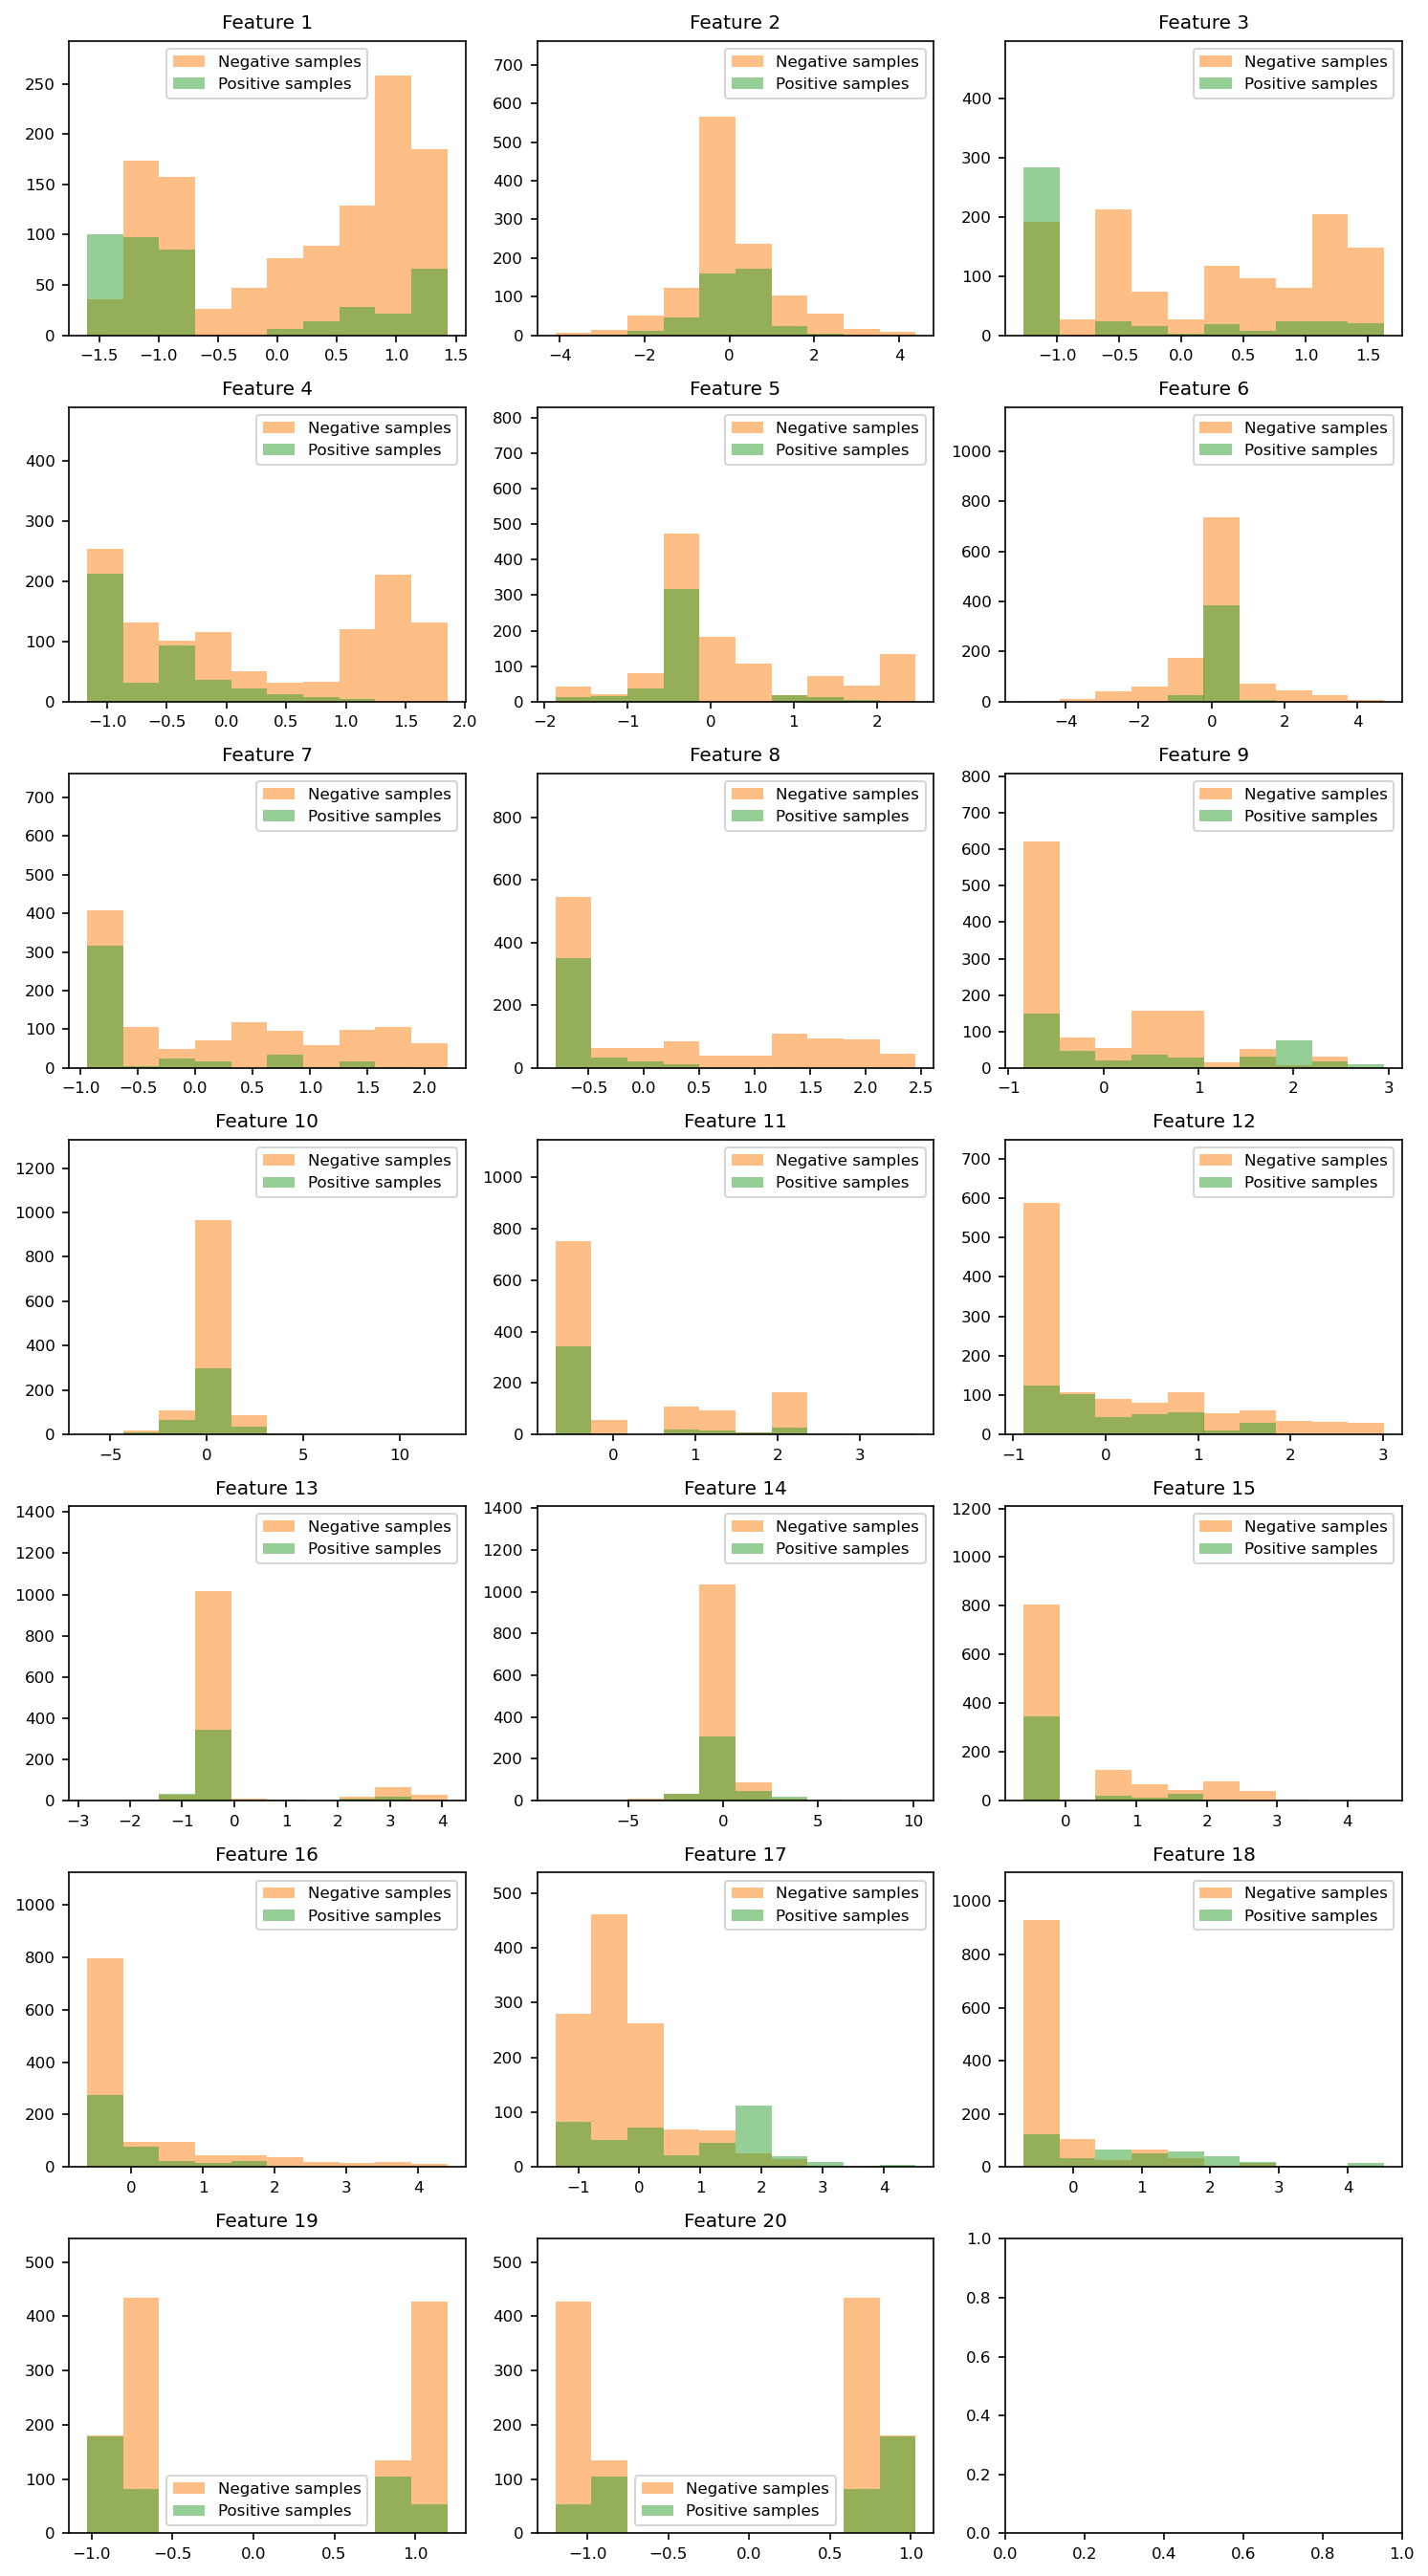

In [5]:
index_0 = np.where(labels_allmoments == 0)[0]
index_1 = np.where(labels_allmoments == 1)[0]

matplotlib.rcParams.update({'font.size':8})
im, ax = plt.subplots(7, 3, figsize = (10, 18), dpi=150)
for i in range (0, 7, 1):
    for j in range (0, 3, 1):
        if ((i == 6) and (j == 2)): continue
        hist, bins, patches = ax[i,j].hist(featurevector_allmoments[:,i*3+j], bins=10, alpha=0.00)
        ax[i,j].hist(featurevector_allmoments[index_0,i*3+j], bins=bins, label='Negative samples', alpha=0.50)
        ax[i,j].hist(featurevector_allmoments[index_1,i*3+j], bins=bins, label='Positive samples', alpha=0.50)
        ax[i,j].set(title='Feature '+str(i*3+j+1))
        ax[i,j].legend()

plt.tight_layout()
plt.show()

In [6]:
data_split = ShuffleSplit(n_splits=10, test_size=0.33, random_state=0)

In [7]:
data_split.split(labels_allmoments)

<generator object BaseShuffleSplit.split at 0x000001CF4C2F1E40>

Next, we introduce the grid search procedure to determined the optimal parameters for the machine learning. The data set will be split according to the data_split function defined above. The parameters to test are different for different models, and therefore the dictionaries are defined differently.

### Case 1. kNN classifier.

In [8]:
# parameter grid
param_grid = {'n_neighbors': [2, 5, 10, 25], \
              'p': [1, 2]}

# classifier and gridsearch
clf = KNeighborsClassifier()
grid_search = GridSearchCV(clf, param_grid, cv=data_split, verbose=1)
grid_search.fit(featurevector_allmoments, labels_allmoments)
print("Best parameters found: ", grid_search.best_params_)
best_params = grid_search.best_params_

# fitting 10 times and accumulating the scores for the best model
tp = np.zeros([10], dtype=int)
tn = np.zeros([10], dtype=int)
fp = np.zeros([10], dtype=int)
fn = np.zeros([10], dtype=int)
acc = np.zeros([10], dtype=float)
tss = np.zeros([10], dtype=float)

for i, split_indexes in enumerate(data_split.split(labels_allmoments)):
    train_index, test_index = split_indexes
    X_train, X_test = featurevector_allmoments[train_index], featurevector_allmoments[test_index]
    f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]
    clf = KNeighborsClassifier(**best_params)
    clf.fit(X_train, f_train)
    f_predicted = clf.predict(X_test)
    tp[i], tn[i], fp[i], fn[i], acc[i], tss[i] = outputclass_analysis_scorereturn(f_test, f_predicted)
    
print("TP = " + str(np.mean(tp)) + "+/-" + str(np.std(tp)))
print("TN = " + str(np.mean(tn)) + "+/-" + str(np.std(tn)))
print("FP = " + str(np.mean(fp)) + "+/-" + str(np.std(fp)))
print("FN = " + str(np.mean(fn)) + "+/-" + str(np.std(fn)))
print("Acc = " + str(np.mean(acc)) + "+/-" + str(np.std(acc)))
print("TSS = " + str(np.mean(tss)) + "+/-" + str(np.std(tss)))

Fitting 10 folds for each of 8 candidates, totalling 80 fits
Best parameters found:  {'n_neighbors': 5, 'p': 1}
TP = 105.1+/-4.763402145525822
TN = 377.8+/-3.1240998703626617
FP = 14.9+/-2.947880594596735
FN = 29.2+/-3.4583232931581165
Acc = 0.9163187855787476+/-0.007371128880286528
TSS = 0.7447115804936696+/-0.024797477333641203


### Case 2. Support vector classifier with RBF kernel

In [9]:
# parameter grid
param_grid = {'kernel': ['rbf'], \
              'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0], \
              'gamma': [0.0001, 0.001, 0.01, 0.1, 1.0, 'scale'], \
              'class_weight': [None, 'balanced']}

# classifier and gridsearch
clf = SVC()
grid_search = GridSearchCV(clf, param_grid, cv=data_split, verbose=2)
grid_search.fit(featurevector_allmoments, labels_allmoments)
print("Best parameters found: ", grid_search.best_params_)
best_params = grid_search.best_params_

# fitting 10 times and accumulating the scores for the best model
tp = np.zeros([10], dtype=int)
tn = np.zeros([10], dtype=int)
fp = np.zeros([10], dtype=int)
fn = np.zeros([10], dtype=int)
acc = np.zeros([10], dtype=float)
tss = np.zeros([10], dtype=float)

for i, split_indexes in enumerate(data_split.split(featurevector_allmoments)):
    train_index, test_index = split_indexes
    X_train, X_test = featurevector_allmoments[train_index], featurevector_allmoments[test_index]
    f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]
    clf = SVC(**best_params)
    clf.fit(X_train, f_train)
    f_predicted = clf.predict(X_test)
    tp[i], tn[i], fp[i], fn[i], acc[i], tss[i] = outputclass_analysis_scorereturn(f_test, f_predicted)
    
print("TP = " + str(np.mean(tp)) + "+/-" + str(np.std(tp)))
print("TN = " + str(np.mean(tn)) + "+/-" + str(np.std(tn)))
print("FP = " + str(np.mean(fp)) + "+/-" + str(np.std(fp)))
print("FN = " + str(np.mean(fn)) + "+/-" + str(np.std(fn)))
print("Acc = " + str(np.mean(acc)) + "+/-" + str(np.std(acc)))
print("TSS = " + str(np.mean(tss)) + "+/-" + str(np.std(tss)))

Fitting 10 folds for each of 96 candidates, totalling 960 fits
[CV] END C=0.001, class_weight=None, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END C=0.001, class_weight=None, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END C=0.001, class_weight=None, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END C=0.001, class_weight=None, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END C=0.001, class_weight=None, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END C=0.001, class_weight=None, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END C=0.001, class_weight=None, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END C=0.001, class_weight=None, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END C=0.001, class_weight=None, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END C=0.001, class_weight=None, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END C=0.001, class_weight=None, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END C=0.001, class_weight=None,

[CV] END C=0.001, class_weight=balanced, gamma=1.0, kernel=rbf; total time=   0.0s
[CV] END C=0.001, class_weight=balanced, gamma=1.0, kernel=rbf; total time=   0.0s
[CV] END C=0.001, class_weight=balanced, gamma=1.0, kernel=rbf; total time=   0.0s
[CV] END C=0.001, class_weight=balanced, gamma=1.0, kernel=rbf; total time=   0.0s
[CV] END C=0.001, class_weight=balanced, gamma=1.0, kernel=rbf; total time=   0.0s
[CV] END C=0.001, class_weight=balanced, gamma=1.0, kernel=rbf; total time=   0.0s
[CV] END C=0.001, class_weight=balanced, gamma=1.0, kernel=rbf; total time=   0.0s
[CV] END C=0.001, class_weight=balanced, gamma=1.0, kernel=rbf; total time=   0.0s
[CV] END C=0.001, class_weight=balanced, gamma=1.0, kernel=rbf; total time=   0.0s
[CV] END C=0.001, class_weight=balanced, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END C=0.001, class_weight=balanced, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END C=0.001, class_weight=balanced, gamma=scale, kernel=rbf; total time=   0.0

[CV] END C=0.01, class_weight=balanced, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] EN

[CV] END C=0.1, class_weight=balanced, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, gamma=0.001, kernel=rbf; total time=   0.1s
[CV] END C=0.1, class_weight=balanced, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, gamma=0.001, kernel=rbf; total time=   0.

[CV] END ....C=1.0, class_weight=None, gamma=1.0, kernel=rbf; total time=   0.0s
[CV] END ....C=1.0, class_weight=None, gamma=1.0, kernel=rbf; total time=   0.0s
[CV] END ....C=1.0, class_weight=None, gamma=1.0, kernel=rbf; total time=   0.0s
[CV] END ....C=1.0, class_weight=None, gamma=1.0, kernel=rbf; total time=   0.0s
[CV] END ....C=1.0, class_weight=None, gamma=1.0, kernel=rbf; total time=   0.0s
[CV] END ....C=1.0, class_weight=None, gamma=1.0, kernel=rbf; total time=   0.0s
[CV] END ..C=1.0, class_weight=None, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ..C=1.0, class_weight=None, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ..C=1.0, class_weight=None, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ..C=1.0, class_weight=None, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ..C=1.0, class_weight=None, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ..C=1.0, class_weight=None, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ..C=1.0, class_weig

[CV] END ..C=10.0, class_weight=None, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ..C=10.0, class_weight=None, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ..C=10.0, class_weight=None, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ...C=10.0, class_weight=None, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ...C=10.0, class_weight=None, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ...C=10.0, class_weight=None, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ...C=10.0, class_weight=None, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ...C=10.0, class_weight=None, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ...C=10.0, class_weight=None, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ...C=10.0, class_weight=None, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ...C=10.0, class_weight=None, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ...C=10.0, class_weight=None, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ...C=10.0, class_we

[CV] END C=100.0, class_weight=None, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END C=100.0, class_weight=None, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END C=100.0, class_weight=None, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END C=100.0, class_weight=None, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END C=100.0, class_weight=None, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END C=100.0, class_weight=None, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END C=100.0, class_weight=None, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END C=100.0, class_weight=None, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END C=100.0, class_weight=None, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END C=100.0, class_weight=None, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END C=100.0, class_weight=None, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END C=100.0, class_weight=None, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .C=100.0, class_w

[CV] END C=100.0, class_weight=balanced, gamma=1.0, kernel=rbf; total time=   0.0s
[CV] END C=100.0, class_weight=balanced, gamma=1.0, kernel=rbf; total time=   0.0s
[CV] END C=100.0, class_weight=balanced, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END C=100.0, class_weight=balanced, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END C=100.0, class_weight=balanced, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END C=100.0, class_weight=balanced, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END C=100.0, class_weight=balanced, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END C=100.0, class_weight=balanced, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END C=100.0, class_weight=balanced, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END C=100.0, class_weight=balanced, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END C=100.0, class_weight=balanced, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END C=100.0, class_weight=balanced, gamma=scale, kernel=rbf; tot

[CV] END C=1000.0, class_weight=balanced, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END C=1000.0, class_weight=balanced, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END C=1000.0, class_weight=balanced, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END C=1000.0, class_weight=balanced, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END C=1000.0, class_weight=balanced, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END C=1000.0, class_weight=balanced, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END C=1000.0, class_weight=balanced, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END C=1000.0, class_weight=balanced, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END C=1000.0, class_weight=balanced, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END C=1000.0, class_weight=balanced, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END C=1000.0, class_weight=balanced, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END C=1000.0, class_weight=balanced, gamma=0.1, kernel=rbf; total tim

[CV] END C=10000.0, class_weight=balanced, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END C=10000.0, class_weight=balanced, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END C=10000.0, class_weight=balanced, gamma=0.001, kernel=rbf; total time=   0.1s
[CV] END C=10000.0, class_weight=balanced, gamma=0.001, kernel=rbf; total time=   0.1s
[CV] END C=10000.0, class_weight=balanced, gamma=0.001, kernel=rbf; total time=   0.2s
[CV] END C=10000.0, class_weight=balanced, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END C=10000.0, class_weight=balanced, gamma=0.001, kernel=rbf; total time=   0.1s
[CV] END C=10000.0, class_weight=balanced, gamma=0.001, kernel=rbf; total time=   0.1s
[CV] END C=10000.0, class_weight=balanced, gamma=0.001, kernel=rbf; total time=   0.1s
[CV] END C=10000.0, class_weight=balanced, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END C=10000.0, class_weight=balanced, gamma=0.001, kernel=rbf; total time=   0.1s
[CV] END C=10000.0, class_weight=balanced

### Case 3. Random Forest

In [10]:
# parameter grid
param_grid = {'n_estimators': [10,50,100,200], \
              'max_depth': [None, 2, 5, 10, 25], \
              'class_weight': [None, 'balanced']}

# classifier and gridsearch
clf = RandomForestClassifier()
grid_search = GridSearchCV(clf, param_grid, cv=data_split, verbose=2)
grid_search.fit(featurevector_allmoments, labels_allmoments)
print("Best parameters found: ", grid_search.best_params_)
best_params = grid_search.best_params_

# fitting 10 times and accumulating the scores for the best model
tp = np.zeros([10], dtype=int)
tn = np.zeros([10], dtype=int)
fp = np.zeros([10], dtype=int)
fn = np.zeros([10], dtype=int)
acc = np.zeros([10], dtype=float)
tss = np.zeros([10], dtype=float)

for i, split_indexes in enumerate(data_split.split(featurevector_allmoments)):
    train_index, test_index = split_indexes
    X_train, X_test = featurevector_allmoments[train_index], featurevector_allmoments[test_index]
    f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]
    clf = RandomForestClassifier(**best_params)
    clf.fit(X_train, f_train)
    f_predicted = clf.predict(X_test)
    tp[i], tn[i], fp[i], fn[i], acc[i], tss[i] = outputclass_analysis_scorereturn(f_test, f_predicted)
    
print("TP = " + str(np.mean(tp)) + "+/-" + str(np.std(tp)))
print("TN = " + str(np.mean(tn)) + "+/-" + str(np.std(tn)))
print("FP = " + str(np.mean(fp)) + "+/-" + str(np.std(fp)))
print("FN = " + str(np.mean(fn)) + "+/-" + str(np.std(fn)))
print("Acc = " + str(np.mean(acc)) + "+/-" + str(np.std(acc)))
print("TSS = " + str(np.mean(tss)) + "+/-" + str(np.std(tss)))

Fitting 10 folds for each of 40 candidates, totalling 400 fits
[CV] END .class_weight=None, max_depth=None, n_estimators=10; total time=   0.0s
[CV] END .class_weight=None, max_depth=None, n_estimators=10; total time=   0.0s
[CV] END .class_weight=None, max_depth=None, n_estimators=10; total time=   0.0s
[CV] END .class_weight=None, max_depth=None, n_estimators=10; total time=   0.0s
[CV] END .class_weight=None, max_depth=None, n_estimators=10; total time=   0.0s
[CV] END .class_weight=None, max_depth=None, n_estimators=10; total time=   0.0s
[CV] END .class_weight=None, max_depth=None, n_estimators=10; total time=   0.0s
[CV] END .class_weight=None, max_depth=None, n_estimators=10; total time=   0.0s
[CV] END .class_weight=None, max_depth=None, n_estimators=10; total time=   0.0s
[CV] END .class_weight=None, max_depth=None, n_estimators=10; total time=   0.0s
[CV] END .class_weight=None, max_depth=None, n_estimators=50; total time=   0.4s
[CV] END .class_weight=None, max_depth=None, n

[CV] END ...class_weight=None, max_depth=5, n_estimators=100; total time=   0.5s
[CV] END ...class_weight=None, max_depth=5, n_estimators=100; total time=   0.5s
[CV] END ...class_weight=None, max_depth=5, n_estimators=100; total time=   0.4s
[CV] END ...class_weight=None, max_depth=5, n_estimators=100; total time=   0.4s
[CV] END ...class_weight=None, max_depth=5, n_estimators=100; total time=   0.4s
[CV] END ...class_weight=None, max_depth=5, n_estimators=100; total time=   0.5s
[CV] END ...class_weight=None, max_depth=5, n_estimators=100; total time=   0.5s
[CV] END ...class_weight=None, max_depth=5, n_estimators=100; total time=   0.5s
[CV] END ...class_weight=None, max_depth=5, n_estimators=100; total time=   0.6s
[CV] END ...class_weight=None, max_depth=5, n_estimators=200; total time=   1.4s
[CV] END ...class_weight=None, max_depth=5, n_estimators=200; total time=   1.4s
[CV] END ...class_weight=None, max_depth=5, n_estimators=200; total time=   1.4s
[CV] END ...class_weight=Non

[CV] END class_weight=balanced, max_depth=None, n_estimators=10; total time=   0.0s
[CV] END class_weight=balanced, max_depth=None, n_estimators=10; total time=   0.0s
[CV] END class_weight=balanced, max_depth=None, n_estimators=10; total time=   0.0s
[CV] END class_weight=balanced, max_depth=None, n_estimators=10; total time=   0.0s
[CV] END class_weight=balanced, max_depth=None, n_estimators=10; total time=   0.0s
[CV] END class_weight=balanced, max_depth=None, n_estimators=10; total time=   0.0s
[CV] END class_weight=balanced, max_depth=None, n_estimators=10; total time=   0.0s
[CV] END class_weight=balanced, max_depth=None, n_estimators=50; total time=   0.2s
[CV] END class_weight=balanced, max_depth=None, n_estimators=50; total time=   0.3s
[CV] END class_weight=balanced, max_depth=None, n_estimators=50; total time=   0.3s
[CV] END class_weight=balanced, max_depth=None, n_estimators=50; total time=   0.2s
[CV] END class_weight=balanced, max_depth=None, n_estimators=50; total time=

[CV] END class_weight=balanced, max_depth=5, n_estimators=100; total time=   0.4s
[CV] END class_weight=balanced, max_depth=5, n_estimators=100; total time=   0.4s
[CV] END class_weight=balanced, max_depth=5, n_estimators=100; total time=   0.4s
[CV] END class_weight=balanced, max_depth=5, n_estimators=100; total time=   0.5s
[CV] END class_weight=balanced, max_depth=5, n_estimators=100; total time=   0.4s
[CV] END class_weight=balanced, max_depth=5, n_estimators=100; total time=   0.4s
[CV] END class_weight=balanced, max_depth=5, n_estimators=100; total time=   0.4s
[CV] END class_weight=balanced, max_depth=5, n_estimators=200; total time=   1.0s
[CV] END class_weight=balanced, max_depth=5, n_estimators=200; total time=   1.0s
[CV] END class_weight=balanced, max_depth=5, n_estimators=200; total time=   1.0s
[CV] END class_weight=balanced, max_depth=5, n_estimators=200; total time=   1.0s
[CV] END class_weight=balanced, max_depth=5, n_estimators=200; total time=   1.0s
[CV] END class_w

### Case 4. Neural Networks

In [11]:
# parameter grid
param_grid = {'hidden_layer_sizes': [(10,), (50,), (200,), (500,)], \
              'max_iter': [100, 250, 1000, 2500, 10000]}

# classifier and gridsearch
clf = MLPClassifier()
grid_search = GridSearchCV(clf, param_grid, cv=data_split, verbose=2)
grid_search.fit(featurevector_allmoments, labels_allmoments)
print("Best parameters found: ", grid_search.best_params_)
best_params = grid_search.best_params_

# fitting 10 times and accumulating the scores for the best model
tp = np.zeros([10], dtype=int)
tn = np.zeros([10], dtype=int)
fp = np.zeros([10], dtype=int)
fn = np.zeros([10], dtype=int)
acc = np.zeros([10], dtype=float)
tss = np.zeros([10], dtype=float)

for i, split_indexes in enumerate(data_split.split(featurevector_allmoments)):
    train_index, test_index = split_indexes
    X_train, X_test = featurevector_allmoments[train_index], featurevector_allmoments[test_index]
    f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]
    clf = MLPClassifier(**best_params)
    clf.fit(X_train, f_train)
    f_predicted = clf.predict(X_test)
    tp[i], tn[i], fp[i], fn[i], acc[i], tss[i] = outputclass_analysis_scorereturn(f_test, f_predicted)
    
print("TP = " + str(np.mean(tp)) + "+/-" + str(np.std(tp)))
print("TN = " + str(np.mean(tn)) + "+/-" + str(np.std(tn)))
print("FP = " + str(np.mean(fp)) + "+/-" + str(np.std(fp)))
print("FN = " + str(np.mean(fn)) + "+/-" + str(np.std(fn)))
print("Acc = " + str(np.mean(acc)) + "+/-" + str(np.std(acc)))
print("TSS = " + str(np.mean(tss)) + "+/-" + str(np.std(tss)))

Fitting 10 folds for each of 20 candidates, totalling 200 fits


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(10,), max_iter=100; total time=   0.4s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(10,), max_iter=100; total time=   0.5s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(10,), max_iter=100; total time=   0.3s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(10,), max_iter=100; total time=   0.5s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(10,), max_iter=100; total time=   0.4s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(10,), max_iter=100; total time=   0.3s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(10,), max_iter=100; total time=   0.2s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(10,), max_iter=100; total time=   0.4s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(10,), max_iter=100; total time=   0.4s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(10,), max_iter=100; total time=   0.3s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(10,), max_iter=250; total time=   0.9s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(10,), max_iter=250; total time=   0.7s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(10,), max_iter=250; total time=   0.6s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(10,), max_iter=250; total time=   0.6s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(10,), max_iter=250; total time=   0.5s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(10,), max_iter=250; total time=   0.5s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(10,), max_iter=250; total time=   0.5s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(10,), max_iter=250; total time=   0.5s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(10,), max_iter=250; total time=   0.5s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(10,), max_iter=250; total time=   0.5s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(10,), max_iter=1000; total time=   2.5s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(10,), max_iter=1000; total time=   2.4s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(10,), max_iter=1000; total time=   3.2s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(10,), max_iter=1000; total time=   2.5s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(10,), max_iter=1000; total time=   2.4s
[CV] END ............hidden_layer_sizes=(10,), max_iter=1000; total time=   2.2s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(10,), max_iter=1000; total time=   3.3s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(10,), max_iter=1000; total time=   3.2s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(10,), max_iter=1000; total time=   2.7s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(10,), max_iter=1000; total time=   2.4s
[CV] END ............hidden_layer_sizes=(10,), max_iter=2500; total time=   1.7s
[CV] END ............hidden_layer_sizes=(10,), max_iter=2500; total time=   2.3s
[CV] END ............hidden_layer_sizes=(10,), max_iter=2500; total time=   3.2s
[CV] END ............hidden_layer_sizes=(10,), max_iter=2500; total time=   3.6s
[CV] END ............hidden_layer_sizes=(10,), max_iter=2500; total time=   4.5s
[CV] END ............hidden_layer_sizes=(10,), max_iter=2500; total time=   3.9s
[CV] END ............hidden_layer_sizes=(10,), max_iter=2500; total time=   4.4s
[CV] END ............hidden_layer_sizes=(10,), max_iter=2500; total time=   2.8s
[CV] END ............hidden_layer_sizes=(10,), max_iter=2500; total time=   2.7s
[CV] END ............hidden_layer_sizes=(10,), max_iter=2500; total time=   3.2s
[CV] END ...........hidden_layer_sizes=(10,), max_iter=10000; total time=   3.5s
[CV] END ...........hidden_l

C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(50,), max_iter=100; total time=   0.5s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(50,), max_iter=100; total time=   0.4s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(50,), max_iter=100; total time=   0.5s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(50,), max_iter=100; total time=   0.5s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(50,), max_iter=100; total time=   0.4s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(50,), max_iter=100; total time=   0.4s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(50,), max_iter=100; total time=   0.4s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(50,), max_iter=100; total time=   0.4s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(50,), max_iter=100; total time=   0.4s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(50,), max_iter=100; total time=   0.4s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(50,), max_iter=250; total time=   1.4s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(50,), max_iter=250; total time=   1.1s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(50,), max_iter=250; total time=   1.2s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(50,), max_iter=250; total time=   1.2s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(50,), max_iter=250; total time=   1.2s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(50,), max_iter=250; total time=   1.2s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(50,), max_iter=250; total time=   1.1s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(50,), max_iter=250; total time=   1.1s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(50,), max_iter=250; total time=   1.2s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(50,), max_iter=250; total time=   1.4s
[CV] END ............hidden_layer_sizes=(50,), max_iter=1000; total time=   4.8s
[CV] END ............hidden_layer_sizes=(50,), max_iter=1000; total time=   4.7s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(50,), max_iter=1000; total time=   5.4s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(50,), max_iter=1000; total time=   5.3s
[CV] END ............hidden_layer_sizes=(50,), max_iter=1000; total time=   4.5s
[CV] END ............hidden_layer_sizes=(50,), max_iter=1000; total time=   5.1s
[CV] END ............hidden_layer_sizes=(50,), max_iter=1000; total time=   5.0s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(50,), max_iter=1000; total time=   4.9s
[CV] END ............hidden_layer_sizes=(50,), max_iter=1000; total time=   4.7s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(50,), max_iter=1000; total time=   5.3s
[CV] END ............hidden_layer_sizes=(50,), max_iter=2500; total time=   4.0s
[CV] END ............hidden_layer_sizes=(50,), max_iter=2500; total time=   4.9s
[CV] END ............hidden_layer_sizes=(50,), max_iter=2500; total time=   5.8s
[CV] END ............hidden_layer_sizes=(50,), max_iter=2500; total time=   5.3s
[CV] END ............hidden_layer_sizes=(50,), max_iter=2500; total time=   5.1s
[CV] END ............hidden_layer_sizes=(50,), max_iter=2500; total time=   5.8s
[CV] END ............hidden_layer_sizes=(50,), max_iter=2500; total time=   5.7s
[CV] END ............hidden_layer_sizes=(50,), max_iter=2500; total time=   5.9s
[CV] END ............hidden_layer_sizes=(50,), max_iter=2500; total time=   6.0s
[CV] END ............hidden_layer_sizes=(50,), max_iter=2500; total time=   5.6s
[CV] END ...........hidden_layer_sizes=(50,), max_iter=10000; total time=   6.2s
[CV] END ...........hidden_l

C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(200,), max_iter=100; total time=   1.4s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(200,), max_iter=100; total time=   2.0s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(200,), max_iter=100; total time=   1.7s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(200,), max_iter=100; total time=   1.9s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(200,), max_iter=100; total time=   2.5s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(200,), max_iter=100; total time=   2.1s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(200,), max_iter=100; total time=   1.5s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(200,), max_iter=100; total time=   1.5s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(200,), max_iter=100; total time=   1.5s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(200,), max_iter=100; total time=   1.8s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(200,), max_iter=250; total time=   5.3s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(200,), max_iter=250; total time=   4.8s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(200,), max_iter=250; total time=   4.1s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(200,), max_iter=250; total time=   3.4s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(200,), max_iter=250; total time=   3.7s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(200,), max_iter=250; total time=   3.4s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(200,), max_iter=250; total time=   3.5s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(200,), max_iter=250; total time=   3.2s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(200,), max_iter=250; total time=   2.8s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(200,), max_iter=250; total time=   2.7s
[CV] END ...........hidden_layer_sizes=(200,), max_iter=1000; total time=   8.2s
[CV] END ...........hidden_layer_sizes=(200,), max_iter=1000; total time=   6.2s
[CV] END ...........hidden_layer_sizes=(200,), max_iter=1000; total time=   8.2s
[CV] END ...........hidden_layer_sizes=(200,), max_iter=1000; total time=   7.3s
[CV] END ...........hidden_layer_sizes=(200,), max_iter=1000; total time=   7.6s
[CV] END ...........hidden_layer_sizes=(200,), max_iter=1000; total time=   8.8s
[CV] END ...........hidden_layer_sizes=(200,), max_iter=1000; total time=   9.1s
[CV] END ...........hidden_layer_sizes=(200,), max_iter=1000; total time=   8.0s
[CV] END ...........hidden_layer_sizes=(200,), max_iter=1000; total time=   8.5s
[CV] END ...........hidden_layer_sizes=(200,), max_iter=1000; total time=  10.0s
[CV] END ...........hidden_layer_sizes=(200,), max_iter=2500; total time=  15.3s
[CV] END ...........hidden_l

C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(500,), max_iter=100; total time=   3.4s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(500,), max_iter=100; total time=   3.4s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(500,), max_iter=100; total time=   2.9s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(500,), max_iter=100; total time=   3.1s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(500,), max_iter=100; total time=   2.5s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(500,), max_iter=100; total time=   2.3s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(500,), max_iter=100; total time=   2.1s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(500,), max_iter=100; total time=   2.1s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(500,), max_iter=100; total time=   2.2s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(500,), max_iter=100; total time=   2.3s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(500,), max_iter=250; total time=   5.8s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(500,), max_iter=250; total time=   5.5s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(500,), max_iter=250; total time=   7.0s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(500,), max_iter=250; total time=   6.1s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(500,), max_iter=250; total time=   9.8s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(500,), max_iter=250; total time=   9.1s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(500,), max_iter=250; total time=  10.3s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(500,), max_iter=250; total time=  10.9s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(500,), max_iter=250; total time=  10.0s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(500,), max_iter=250; total time=  10.2s
[CV] END ...........hidden_layer_sizes=(500,), max_iter=1000; total time=  11.4s
[CV] END ...........hidden_layer_sizes=(500,), max_iter=1000; total time=  16.5s
[CV] END ...........hidden_layer_sizes=(500,), max_iter=1000; total time=  14.6s
[CV] END ...........hidden_layer_sizes=(500,), max_iter=1000; total time=   8.0s
[CV] END ...........hidden_layer_sizes=(500,), max_iter=1000; total time=  13.1s
[CV] END ...........hidden_layer_sizes=(500,), max_iter=1000; total time=  11.1s
[CV] END ...........hidden_layer_sizes=(500,), max_iter=1000; total time=   8.4s
[CV] END ...........hidden_layer_sizes=(500,), max_iter=1000; total time=   9.8s
[CV] END ...........hidden_layer_sizes=(500,), max_iter=1000; total time=  10.8s
[CV] END ...........hidden_layer_sizes=(500,), max_iter=1000; total time=  12.5s
[CV] END ...........hidden_layer_sizes=(500,), max_iter=2500; total time=  12.1s
[CV] END ...........hidden_l

### Visualizations for the best-fitted classifiers

In [8]:
# fitting 10 times and accumulating the scores for the best model
tp = np.zeros([10], dtype=int)
tn = np.zeros([10], dtype=int)
fp = np.zeros([10], dtype=int)
fn = np.zeros([10], dtype=int)
acc = np.zeros([10], dtype=float)
tss = np.zeros([10], dtype=float)

for i, split_indexes in enumerate(data_split.split(labels_allmoments)):
    train_index, test_index = split_indexes
    X_train, X_test = featurevector_allmoments[train_index], featurevector_allmoments[test_index]
    f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]
    clf = KNeighborsClassifier(n_neighbors=5, p=1)
    clf.fit(X_train, f_train)
    f_predicted = clf.predict(X_test)
    tp[i], tn[i], fp[i], fn[i], acc[i], tss[i] = outputclass_analysis_scorereturn(f_test, f_predicted)
    
print("TP = " + str(np.mean(tp)) + "+/-" + str(np.std(tp)))
print("TN = " + str(np.mean(tn)) + "+/-" + str(np.std(tn)))
print("FP = " + str(np.mean(fp)) + "+/-" + str(np.std(fp)))
print("FN = " + str(np.mean(fn)) + "+/-" + str(np.std(fn)))
print("Acc = " + str(np.mean(acc)) + "+/-" + str(np.std(acc)))
print("TSS = " + str(np.mean(tss)) + "+/-" + str(np.std(tss)))

tp_knn = np.copy(tp)
tn_knn = np.copy(tn)
fp_knn = np.copy(fp)
fn_knn = np.copy(fn)
acc_knn = np.copy(acc)
tss_knn = np.copy(tss)

TP = 105.1+/-4.763402145525822
TN = 377.8+/-3.1240998703626617
FP = 14.9+/-2.947880594596735
FN = 29.2+/-3.4583232931581165
Acc = 0.9163187855787476+/-0.007371128880286528
TSS = 0.7447115804936696+/-0.024797477333641203


In [9]:
# fitting 10 times and accumulating the scores for the best model
tp = np.zeros([10], dtype=int)
tn = np.zeros([10], dtype=int)
fp = np.zeros([10], dtype=int)
fn = np.zeros([10], dtype=int)
acc = np.zeros([10], dtype=float)
tss = np.zeros([10], dtype=float)

for i, split_indexes in enumerate(data_split.split(featurevector_allmoments)):
    train_index, test_index = split_indexes
    X_train, X_test = featurevector_allmoments[train_index], featurevector_allmoments[test_index]
    f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]
    clf = SVC(C=10000.0, class_weight=None, gamma='scale', kernel='rbf')
    clf.fit(X_train, f_train)
    f_predicted = clf.predict(X_test)
    tp[i], tn[i], fp[i], fn[i], acc[i], tss[i] = outputclass_analysis_scorereturn(f_test, f_predicted)
    
print("TP = " + str(np.mean(tp)) + "+/-" + str(np.std(tp)))
print("TN = " + str(np.mean(tn)) + "+/-" + str(np.std(tn)))
print("FP = " + str(np.mean(fp)) + "+/-" + str(np.std(fp)))
print("FN = " + str(np.mean(fn)) + "+/-" + str(np.std(fn)))
print("Acc = " + str(np.mean(acc)) + "+/-" + str(np.std(acc)))
print("TSS = " + str(np.mean(tss)) + "+/-" + str(np.std(tss)))

tp_svm = np.copy(tp)
tn_svm = np.copy(tn)
fp_svm = np.copy(fp)
fn_svm = np.copy(fn)
acc_svm = np.copy(acc)
tss_svm = np.copy(tss)

TP = 115.7+/-6.986415389883427
TN = 372.3+/-5.000999900019995
FP = 20.4+/-3.411744421846396
FN = 18.6+/-4.565084884205331
Acc = 0.9259962049335864+/-0.010767560500274071
TSS = 0.8091909399565932+/-0.036525468176668796


In [10]:
# fitting 10 times and accumulating the scores for the best model
tp = np.zeros([10], dtype=int)
tn = np.zeros([10], dtype=int)
fp = np.zeros([10], dtype=int)
fn = np.zeros([10], dtype=int)
acc = np.zeros([10], dtype=float)
tss = np.zeros([10], dtype=float)

for i, split_indexes in enumerate(data_split.split(featurevector_allmoments)):
    print ("Processing partition " + str(i))
    train_index, test_index = split_indexes
    X_train, X_test = featurevector_allmoments[train_index], featurevector_allmoments[test_index]
    f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]
    clf = RandomForestClassifier(class_weight = None, max_depth = None, n_estimators = 200, random_state=1)
    clf.fit(X_train, f_train)
    f_predicted = clf.predict(X_test)
    tp[i], tn[i], fp[i], fn[i], acc[i], tss[i] = outputclass_analysis_scorereturn(f_test, f_predicted)
    
print("TP = " + str(np.mean(tp)) + "+/-" + str(np.std(tp)))
print("TN = " + str(np.mean(tn)) + "+/-" + str(np.std(tn)))
print("FP = " + str(np.mean(fp)) + "+/-" + str(np.std(fp)))
print("FN = " + str(np.mean(fn)) + "+/-" + str(np.std(fn)))
print("Acc = " + str(np.mean(acc)) + "+/-" + str(np.std(acc)))
print("TSS = " + str(np.mean(tss)) + "+/-" + str(np.std(tss)))

tp_rf = np.copy(tp)
tn_rf = np.copy(tn)
fp_rf = np.copy(fp)
fn_rf = np.copy(fn)
acc_rf = np.copy(acc)
tss_rf = np.copy(tss)

Processing partition 0
Processing partition 1
Processing partition 2
Processing partition 3
Processing partition 4
Processing partition 5
Processing partition 6
Processing partition 7
Processing partition 8
Processing partition 9
TP = 122.2+/-5.7236352085016735
TN = 385.7+/-4.838388161361178
FP = 7.0+/-2.932575659723036
FN = 12.1+/-3.5341194094144583
Acc = 0.9637571157495257+/-0.007658609514463196
TSS = 0.8919761237468485+/-0.02621442905914648


In [11]:
# fitting 10 times and accumulating the scores for the best model
tp = np.zeros([10], dtype=int)
tn = np.zeros([10], dtype=int)
fp = np.zeros([10], dtype=int)
fn = np.zeros([10], dtype=int)
acc = np.zeros([10], dtype=float)
tss = np.zeros([10], dtype=float)

for i, split_indexes in enumerate(data_split.split(featurevector_allmoments)):
    print ("Processing partition " + str(i))
    train_index, test_index = split_indexes
    X_train, X_test = featurevector_allmoments[train_index], featurevector_allmoments[test_index]
    f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]
    clf = MLPClassifier(hidden_layer_sizes = (500,), max_iter=1000, random_state=1)
    clf.fit(X_train, f_train)
    f_predicted = clf.predict(X_test)
    tp[i], tn[i], fp[i], fn[i], acc[i], tss[i] = outputclass_analysis_scorereturn(f_test, f_predicted)
    
print("TP = " + str(np.mean(tp)) + "+/-" + str(np.std(tp)))
print("TN = " + str(np.mean(tn)) + "+/-" + str(np.std(tn)))
print("FP = " + str(np.mean(fp)) + "+/-" + str(np.std(fp)))
print("FN = " + str(np.mean(fn)) + "+/-" + str(np.std(fn)))
print("Acc = " + str(np.mean(acc)) + "+/-" + str(np.std(acc)))
print("TSS = " + str(np.mean(tss)) + "+/-" + str(np.std(tss)))

tp_mlp = np.copy(tp)
tn_mlp = np.copy(tn)
fp_mlp = np.copy(fp)
fn_mlp = np.copy(fn)
acc_mlp = np.copy(acc)
tss_mlp = np.copy(tss)

Processing partition 0
Processing partition 1
Processing partition 2
Processing partition 3
Processing partition 4
Processing partition 5
Processing partition 6
Processing partition 7
Processing partition 8
Processing partition 9
TP = 110.2+/-5.015974481593781
TN = 375.9+/-5.3188344587888805
FP = 16.8+/-3.815756805667783
FN = 24.1+/-3.0149626863362675
Acc = 0.9223908918406071+/-0.004758989071720855
TSS = 0.7777012920719378+/-0.016477189939684445


In [12]:
# from the CNN notebook

acc_cnn15 = np.array([0.9278937381404174, 0.9259962049335864, 0.9259962049335864, 0.8918406072106262, 0.9278937381404174, \
0.889943074003795, 0.8994307400379506, 0.9032258064516129, 0.9354838709677419, 0.9089184060721063], dtype=float)

tss_cnn15 = np.array([0.7541315216976452, 0.776497080264112, 0.7332752354817177, 0.6202104097452934, 0.7705176408036155, \
0.5919676629830156, 0.6026545243169927, 0.6654120002966698, 0.7469128588679833, 0.6274212598425197], dtype=float)

acc_cnn10 = np.array([0.9297912713472486, 0.9316888045540797, 0.9184060721062619, 0.8994307400379506, 0.9278937381404174, \
0.9070208728652751, 0.9013282732447818, 0.9165085388994307, 0.9013282732447818, 0.9089184060721063], dtype=float)

tss_cnn10 = np.array([0.7467081409106523, 0.7641883897561161, 0.6998813320477638, 0.6396640826873385, 0.7951084273290038, \
0.6890343395386783, 0.620693664018601, 0.711154787510198, 0.607377975147053, 0.6381692913385827], dtype=float)

#ARCH = VDFCNN_4040_CNN1_CONN1
#TP = 94.4+/-10.49952379872535
#TN = 387.1+/-6.640030120413611
#FP = 5.6+/-4.17612260356422
#FN = 39.9+/-10.662551289442879
#Acc = 0.9136622390891841+/-0.015994527903519178
#TSS = 0.6889000194299565+/-0.07057494879088673

#ARCH = VDFCNN_6060_CNN1_CONN1
#TP = 94.9+/-10.377379245262263
#TN = 386.9+/-6.5337584895678535
#FP = 5.8+/-3.994996871087636
#FN = 39.4+/-8.83402513014311
#Acc = 0.9142314990512335+/-0.01178305479792031
#TSS = 0.6911980430283988+/-0.06095010355408021

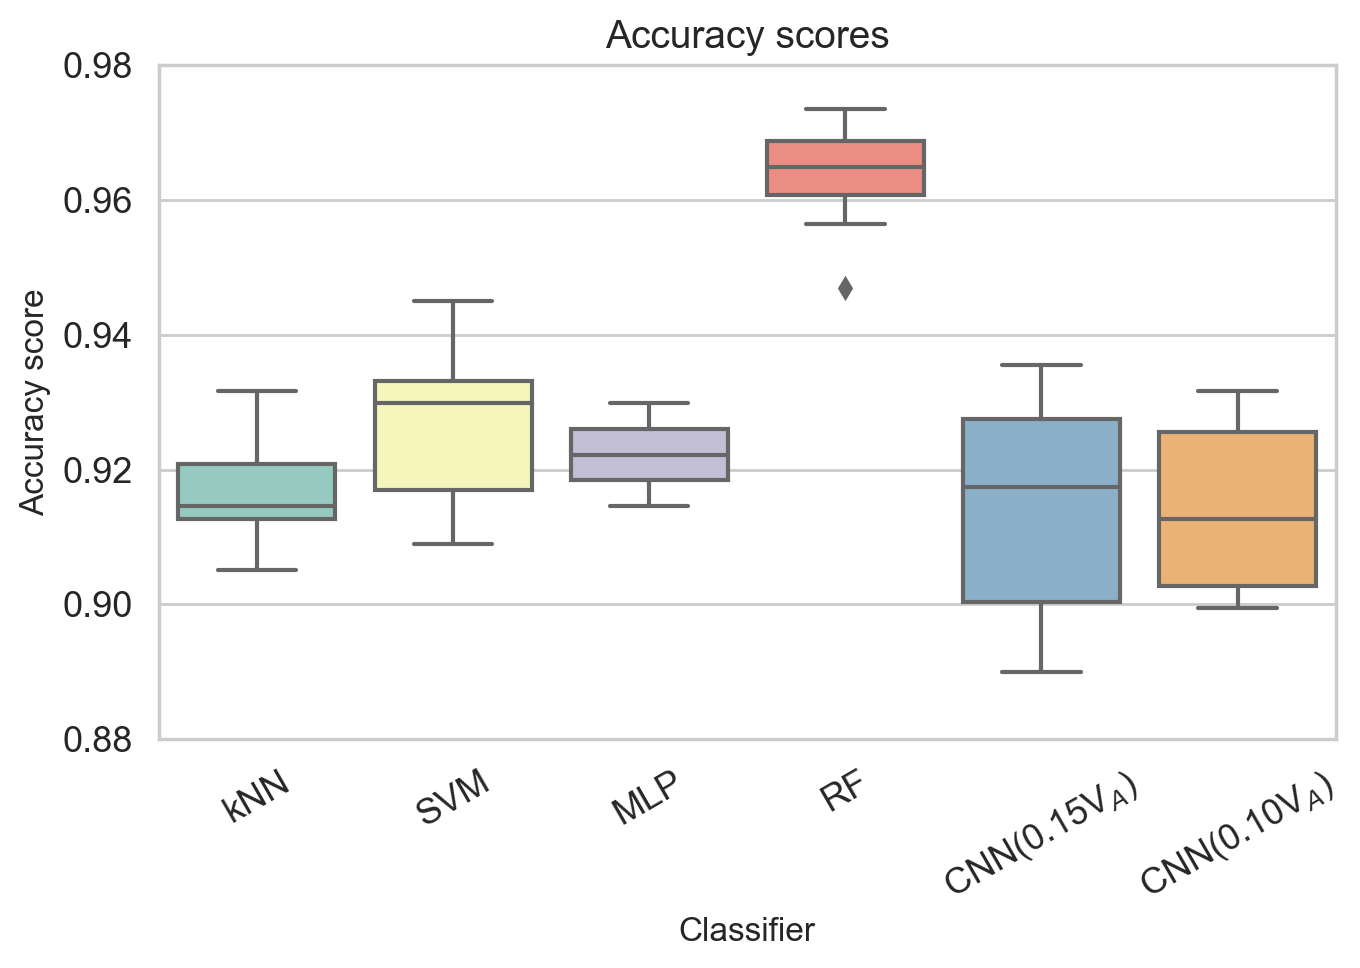

In [22]:
matplotlib.rcParams.update({'font.size':10})

im, ax = plt.subplots(1, 1, figsize=(7,5), dpi=200)
sns.set(style="whitegrid")

data = {
    'kNN': acc_knn,
    'SVM': acc_svm,
    'MLP': acc_mlp,
    'RF': acc_rf,
    r'CNN(0.15V$_{A}$)': acc_cnn15,
    r'CNN(0.10V$_{A}$)': acc_cnn10
} 

df = pd.DataFrame([(group, score) for group, scores in data.items() for score in scores], \
                  columns=['Classifier', 'Accuracy score'])

ax = sns.boxplot(x='Classifier', y='Accuracy score', data=df, palette="Set3")
ax.set(ylim=[0.88,0.98])

plt.xticks(rotation=30, fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel("Classifier",fontsize=13)
plt.ylabel("Accuracy score",fontsize=13)
plt.title("Accuracy scores",fontsize=14)
plt.tight_layout()
plt.savefig('./visualizations_paper/accuracy_boxplot.png')
plt.show()

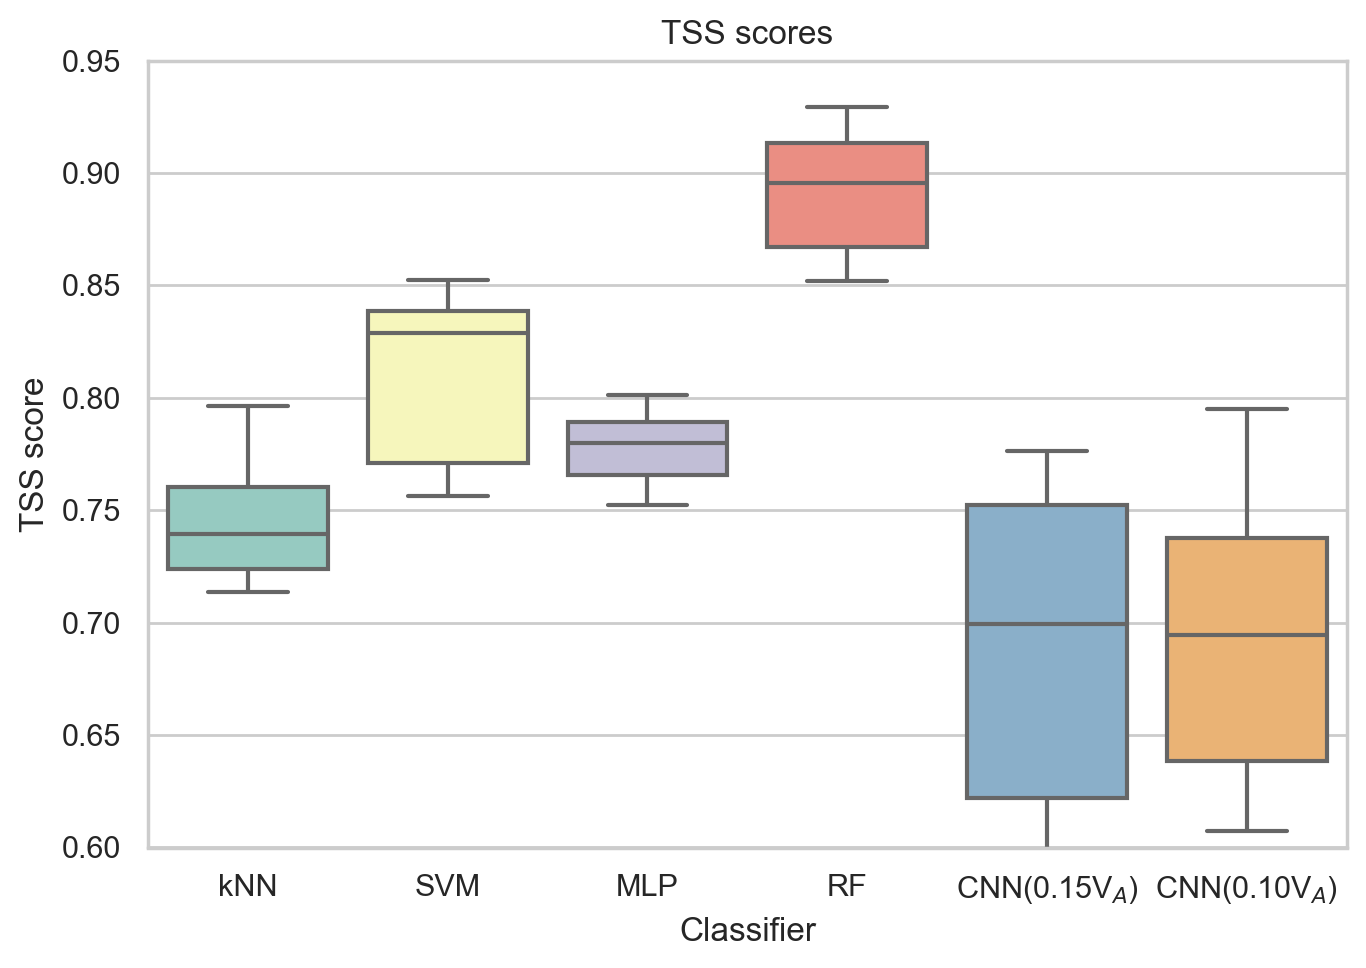

In [14]:
matplotlib.rcParams.update({'font.size':12})

im, ax = plt.subplots(1, 1, figsize=(7,5), dpi=200)
sns.set(style="whitegrid")

data = {
    'kNN': tss_knn,
    'SVM': tss_svm,
    'MLP': tss_mlp,
    'RF': tss_rf, 
    r'CNN(0.15V$_{A}$)': tss_cnn15,
    r'CNN(0.10V$_{A}$)': tss_cnn10
}

#, 
#    

df = pd.DataFrame([(group, score) for group, scores in data.items() for score in scores], \
                  columns=['Classifier', 'TSS score'])

ax = sns.boxplot(x='Classifier', y='TSS score', data=df, palette="Set3")
ax.set(xlabel='Classifier', ylabel='TSS score', title='TSS scores')
ax.set(ylim=[0.60,0.95])

plt.tight_layout()
plt.savefig('./visualizations_paper/tss_boxplot.png')
plt.show()

## Test 2. Testing performance for any 'unseen' run

In [10]:
featurevector_allmoments = np.load('./mldata_vdfmoments/allsimulations.featurevector_allmoments_all.npy')
times_allmoments = np.load('./mldata_vdfmoments/allsimulations.timep_array_all.npy')
labels_an = np.load('./mldata_vdfmoments/allsimulations.labels_allmoments_an_01_all.npy')
labels_me = np.load('./mldata_vdfmoments/allsimulations.labels_allmoments_me_01_all.npy')
simnames = np.load('./mldata_vdfmoments/allsimulations.simnames_all.npy')
# merging both labels
labels_allmoments = np.copy(labels_me)
labels_allmoments[np.where(labels_an == 1)] = 1

print('The total number of data points is: ' + str(len(labels_allmoments)))
print('Among them unstable (positive) samples: ' + str(len(np.where(labels_allmoments == 1)[0])))

The total number of data points is: 1596
Among them unstable (positive) samples: 418


In [11]:
scaler = StandardScaler()
scaler.fit(featurevector_allmoments)
featurevector_allmoments = scaler.transform(featurevector_allmoments)

In [12]:
simfiles = [\
'particles.d11_A0.5Hepp_beta0.5eps1e-4_256',\
'particles.d11_A0.75Hepp_beta1_256',\
'particles.d11_E11Ap3.3Aa2.0Vd0.42',\
'particles.d11_E11Ap4.3Aa1.6',\
'particles.d11_E11Ap4.3Aa1.6Vd0.32',\
'particles.d11_E12Ap1.86Aa1.0Vd0.32_512_256x256',\
'particles.d11_He++A10_256_iden0eps0',\
'particles.d11_He++v2_256_iden0eps1e-4t600',\
'particles.d11_He++vd1.5_256_iden0eps1e-4',\
'particles.d11_pv1.5_128_64_iden0eps1e-4_dx0.75_long',\
'particles.d11_pv1Ap2Apb2betac0.214betab0.858_128_128x2_dx0.75_t3000',\
'particles.d11_pv2a_128x3_iden0eps1e-4_dx0.75',\
'particles.d11_pv2Ap1Ab1betac0.429betab0.858_128_128x2_dx0.75_t3000',\
'particles.d11_pv2Ap1Ab2betac0.429betab0.858_128_128x2_dx0.75_t3000',\
'particles.d11_pv2Ap2Apb2betac0.214betab0.858_128_128x2_dx0.75_t3000',\
'particles.d11_pv2av2.3_128x3_iden0eps1e-4_dx0.75',\
'particles.d11_pv2av2_rdna0.03375_128x3_iden0eps1e-4_dx0.75_t6000',\
'particles.d11_vap1.2Ap1Aa0.75_rdna_0.05',\
'particles.d11_vap1.2Ap3.35Aa2.05rdna_0.007',\
'particles.d11_vap1.5Ap1.5Aa1rdna_0.007',\
'particles.d11_e260945ap1.30.5_1',\
'particles.d11_e260955ap2.20.4_2',\
'particles.d11_e261013ap1.50.6_3',\
'particles.d11_e261016ap1.70.6_4',\
'particles.d11_e261019ap1.50.4_5',\
'particles.d11_e261022ap1.40.4_6',\
'particles.d11_e261040ap1.40.4_7',\
'particles.d11_pv1.4av2Ap2Apb2betac0.214betab0.858_128_128x4_dx0.75',\
'particles.d11_pv2Ap2Apb2beta_pb0.429_128_128x2_dx0.75',\
'particles.d11_pv2av1.4Ap1Aa1betac0.214betab0.858_128_128x4_dx0.75',\
'particles.d11_pv2av1.4Ap2Aa2betac0.214betab0.858_128_128x4_dx0.75',\
'particles.d11_pv2av1.4Ap2Ab2beta0.429_128_128x4_dx0.75_t3000',\
'particles.d11_pv2av2Ap1Aa1beta0.429_128_128x4_dx0.75_t3000',\
'particles.d11_pv2av2Ap2Aa2beta0.429_128_128x4_dx0.75_t3000']

All negative forecast

In [13]:
# organizing training and testing for every simfile in its absence
accuracies = []
for simfile in simfiles:
    train_index = np.where(simnames != simfile)[0]
    test_index = np.where(simnames == simfile)[0]
    X_train, X_test = featurevector_allmoments[train_index], featurevector_allmoments[test_index]
    f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]
    f_predicted = f_test*0
    tp, tn, fp, fn, acc, tss = outputclass_analysis_scorereturn(f_test, f_predicted)
    # summary for the run (printout)
    print('-------- RUN: ' + simfile + ' --------')
    print('tp=' + str(tp) + ', tn=' + str(tn) + ', fp=' + str(fp) + ', fn=' + str(fn), ', accuracy=' + str(acc)[0:4])
    accuracies.append(acc)

accuracies = np.array(accuracies, dtype='float')
print('------------------------------------------------------')
print('------------------------------------------------------')
print('Mean accuracies on unseen runs:')
print('Acc = ' + str(np.mean(accuracies))[0:4] + '+/-' + str(np.std(accuracies))[0:4])

-------- RUN: particles.d11_A0.5Hepp_beta0.5eps1e-4_256 --------
tp=0, tn=78, fp=0, fn=0 , accuracy=1.0
-------- RUN: particles.d11_A0.75Hepp_beta1_256 --------
tp=0, tn=46, fp=0, fn=0 , accuracy=1.0
-------- RUN: particles.d11_E11Ap3.3Aa2.0Vd0.42 --------
tp=0, tn=26, fp=0, fn=20 , accuracy=0.56
-------- RUN: particles.d11_E11Ap4.3Aa1.6 --------
tp=0, tn=6, fp=0, fn=40 , accuracy=0.13
-------- RUN: particles.d11_E11Ap4.3Aa1.6Vd0.32 --------
tp=0, tn=5, fp=0, fn=41 , accuracy=0.10
-------- RUN: particles.d11_E12Ap1.86Aa1.0Vd0.32_512_256x256 --------
tp=0, tn=48, fp=0, fn=0 , accuracy=1.0
-------- RUN: particles.d11_He++A10_256_iden0eps0 --------
tp=0, tn=1, fp=0, fn=45 , accuracy=0.02
-------- RUN: particles.d11_He++v2_256_iden0eps1e-4t600 --------
tp=0, tn=6, fp=0, fn=84 , accuracy=0.06
-------- RUN: particles.d11_He++vd1.5_256_iden0eps1e-4 --------
tp=0, tn=28, fp=0, fn=50 , accuracy=0.35
-------- RUN: particles.d11_pv1.5_128_64_iden0eps1e-4_dx0.75_long --------
tp=0, tn=114, fp=0, f

### Statistics for every run using Random Forest (best parameters)

In [24]:
# organizing training and testing for every simfile in its absence
accuracies = []
for simfile in simfiles:
    train_index = np.where(simnames != simfile)[0]
    test_index = np.where(simnames == simfile)[0]
    X_train, X_test = featurevector_allmoments[train_index], featurevector_allmoments[test_index]
    f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]
    clf = RandomForestClassifier(class_weight = None, max_depth = None, n_estimators = 200, random_state=1)
    clf.fit(X_train, f_train)
    f_predicted = clf.predict(X_test)
    tp, tn, fp, fn, acc, tss = outputclass_analysis_scorereturn(f_test, f_predicted)
    # summary for the run (printout)
    print('-------- RUN: ' + simfile + ' --------')
    print('tp=' + str(tp) + ', tn=' + str(tn) + ', fp=' + str(fp) + ', fn=' + str(fn), ', accuracy=' + str(acc)[0:4])
    accuracies.append(acc)

accuracies = np.array(accuracies, dtype='float')
print('------------------------------------------------------')
print('------------------------------------------------------')
print('Mean accuracies on unseen runs:')
print('Acc = ' + str(np.mean(accuracies))[0:4] + '+/-' + str(np.std(accuracies))[0:4])
accuracies_rf = np.copy(accuracies)

-------- RUN: particles.d11_A0.5Hepp_beta0.5eps1e-4_256 --------
tp=0, tn=78, fp=0, fn=0 , accuracy=1.0
-------- RUN: particles.d11_A0.75Hepp_beta1_256 --------
tp=0, tn=46, fp=0, fn=0 , accuracy=1.0
-------- RUN: particles.d11_E11Ap3.3Aa2.0Vd0.42 --------
tp=20, tn=0, fp=26, fn=0 , accuracy=0.43
-------- RUN: particles.d11_E11Ap4.3Aa1.6 --------
tp=40, tn=0, fp=6, fn=0 , accuracy=0.86
-------- RUN: particles.d11_E11Ap4.3Aa1.6Vd0.32 --------
tp=26, tn=5, fp=0, fn=15 , accuracy=0.67
-------- RUN: particles.d11_E12Ap1.86Aa1.0Vd0.32_512_256x256 --------
tp=0, tn=21, fp=27, fn=0 , accuracy=0.43
-------- RUN: particles.d11_He++A10_256_iden0eps0 --------
tp=45, tn=0, fp=1, fn=0 , accuracy=0.97
-------- RUN: particles.d11_He++v2_256_iden0eps1e-4t600 --------
tp=19, tn=6, fp=0, fn=65 , accuracy=0.27
-------- RUN: particles.d11_He++vd1.5_256_iden0eps1e-4 --------
tp=50, tn=0, fp=28, fn=0 , accuracy=0.64
-------- RUN: particles.d11_pv1.5_128_64_iden0eps1e-4_dx0.75_long --------
tp=0, tn=114, fp=

### Statistics for every run using kNN classifier (best parameters)

In [25]:
# organizing training and testing for every simfile in its absence
accuracies = []
for simfile in simfiles:
    train_index = np.where(simnames != simfile)[0]
    test_index = np.where(simnames == simfile)[0]
    X_train, X_test = featurevector_allmoments[train_index], featurevector_allmoments[test_index]
    f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]
    clf = KNeighborsClassifier(n_neighbors=5, p=1)
    clf.fit(X_train, f_train)
    f_predicted = clf.predict(X_test)
    tp, tn, fp, fn, acc, tss = outputclass_analysis_scorereturn(f_test, f_predicted)
    # summary for the run (printout)
    print('-------- RUN: ' + simfile + ' --------')
    print('tp=' + str(tp) + ', tn=' + str(tn) + ', fp=' + str(fp) + ', fn=' + str(fn), ', accuracy=' + str(acc)[0:4])
    accuracies.append(acc)

accuracies = np.array(accuracies, dtype='float')
print('------------------------------------------------------')
print('------------------------------------------------------')
print('Mean accuracies on unseen runs:')
print('Acc = ' + str(np.mean(accuracies))[0:4] + '+/-' + str(np.std(accuracies))[0:4])
accuracies_knn = np.copy(accuracies)

-------- RUN: particles.d11_A0.5Hepp_beta0.5eps1e-4_256 --------
tp=0, tn=0, fp=78, fn=0 , accuracy=0.0
-------- RUN: particles.d11_A0.75Hepp_beta1_256 --------
tp=0, tn=46, fp=0, fn=0 , accuracy=1.0
-------- RUN: particles.d11_E11Ap3.3Aa2.0Vd0.42 --------
tp=20, tn=0, fp=26, fn=0 , accuracy=0.43
-------- RUN: particles.d11_E11Ap4.3Aa1.6 --------
tp=35, tn=0, fp=6, fn=5 , accuracy=0.76
-------- RUN: particles.d11_E11Ap4.3Aa1.6Vd0.32 --------
tp=35, tn=0, fp=5, fn=6 , accuracy=0.76
-------- RUN: particles.d11_E12Ap1.86Aa1.0Vd0.32_512_256x256 --------
tp=0, tn=47, fp=1, fn=0 , accuracy=0.97
-------- RUN: particles.d11_He++A10_256_iden0eps0 --------
tp=45, tn=0, fp=1, fn=0 , accuracy=0.97
-------- RUN: particles.d11_He++v2_256_iden0eps1e-4t600 --------
tp=13, tn=5, fp=1, fn=71 , accuracy=0.2
-------- RUN: particles.d11_He++vd1.5_256_iden0eps1e-4 --------
tp=33, tn=5, fp=23, fn=17 , accuracy=0.48
-------- RUN: particles.d11_pv1.5_128_64_iden0eps1e-4_dx0.75_long --------
tp=0, tn=114, fp=0,

### Statistics for every run using SVM classifier (best parameters)

In [26]:
# organizing training and testing for every simfile in its absence
accuracies = []
for simfile in simfiles:
    train_index = np.where(simnames != simfile)[0]
    test_index = np.where(simnames == simfile)[0]
    X_train, X_test = featurevector_allmoments[train_index], featurevector_allmoments[test_index]
    f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]
    clf = SVC(C=10000.0, class_weight=None, gamma='scale', kernel='rbf')
    clf.fit(X_train, f_train)
    f_predicted = clf.predict(X_test)
    tp, tn, fp, fn, acc, tss = outputclass_analysis_scorereturn(f_test, f_predicted)
    # summary for the run (printout)
    print('-------- RUN: ' + simfile + ' --------')
    print('tp=' + str(tp) + ', tn=' + str(tn) + ', fp=' + str(fp) + ', fn=' + str(fn), ', accuracy=' + str(acc)[0:4])
    accuracies.append(acc)

accuracies = np.array(accuracies, dtype='float')
print('------------------------------------------------------')
print('------------------------------------------------------')
print('Mean accuracies on unseen runs:')
print('Acc = ' + str(np.mean(accuracies))[0:4] + '+/-' + str(np.std(accuracies))[0:4])
accuracies_svm = np.copy(accuracies)

-------- RUN: particles.d11_A0.5Hepp_beta0.5eps1e-4_256 --------
tp=0, tn=78, fp=0, fn=0 , accuracy=1.0
-------- RUN: particles.d11_A0.75Hepp_beta1_256 --------
tp=0, tn=0, fp=46, fn=0 , accuracy=0.0
-------- RUN: particles.d11_E11Ap3.3Aa2.0Vd0.42 --------
tp=20, tn=0, fp=26, fn=0 , accuracy=0.43
-------- RUN: particles.d11_E11Ap4.3Aa1.6 --------
tp=34, tn=6, fp=0, fn=6 , accuracy=0.86
-------- RUN: particles.d11_E11Ap4.3Aa1.6Vd0.32 --------
tp=38, tn=0, fp=5, fn=3 , accuracy=0.82
-------- RUN: particles.d11_E12Ap1.86Aa1.0Vd0.32_512_256x256 --------
tp=0, tn=48, fp=0, fn=0 , accuracy=1.0
-------- RUN: particles.d11_He++A10_256_iden0eps0 --------
tp=45, tn=0, fp=1, fn=0 , accuracy=0.97
-------- RUN: particles.d11_He++v2_256_iden0eps1e-4t600 --------
tp=31, tn=3, fp=3, fn=53 , accuracy=0.37
-------- RUN: particles.d11_He++vd1.5_256_iden0eps1e-4 --------
tp=32, tn=1, fp=27, fn=18 , accuracy=0.42
-------- RUN: particles.d11_pv1.5_128_64_iden0eps1e-4_dx0.75_long --------
tp=0, tn=114, fp=0,

### Statistics for every run using MLP classifier (best parameters)

In [27]:
# organizing training and testing for every simfile in its absence
accuracies = []
for simfile in simfiles:
    train_index = np.where(simnames != simfile)[0]
    test_index = np.where(simnames == simfile)[0]
    X_train, X_test = featurevector_allmoments[train_index], featurevector_allmoments[test_index]
    f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]
    clf = MLPClassifier(hidden_layer_sizes = (500,), max_iter=1000, random_state=1)
    clf.fit(X_train, f_train)
    f_predicted = clf.predict(X_test)
    tp, tn, fp, fn, acc, tss = outputclass_analysis_scorereturn(f_test, f_predicted)
    # summary for the run (printout)
    print('-------- RUN: ' + simfile + ' --------')
    print('tp=' + str(tp) + ', tn=' + str(tn) + ', fp=' + str(fp) + ', fn=' + str(fn), ', accuracy=' + str(acc)[0:4])
    accuracies.append(acc)

accuracies = np.array(accuracies, dtype='float')
print('------------------------------------------------------')
print('------------------------------------------------------')
print('Mean accuracies on unseen runs:')
print('Acc = ' + str(np.mean(accuracies))[0:4] + '+/-' + str(np.std(accuracies))[0:4])
accuracies_mlp = np.copy(accuracies)

-------- RUN: particles.d11_A0.5Hepp_beta0.5eps1e-4_256 --------
tp=0, tn=78, fp=0, fn=0 , accuracy=1.0
-------- RUN: particles.d11_A0.75Hepp_beta1_256 --------
tp=0, tn=46, fp=0, fn=0 , accuracy=1.0
-------- RUN: particles.d11_E11Ap3.3Aa2.0Vd0.42 --------
tp=20, tn=0, fp=26, fn=0 , accuracy=0.43
-------- RUN: particles.d11_E11Ap4.3Aa1.6 --------
tp=40, tn=0, fp=6, fn=0 , accuracy=0.86
-------- RUN: particles.d11_E11Ap4.3Aa1.6Vd0.32 --------
tp=31, tn=3, fp=2, fn=10 , accuracy=0.73
-------- RUN: particles.d11_E12Ap1.86Aa1.0Vd0.32_512_256x256 --------
tp=0, tn=48, fp=0, fn=0 , accuracy=1.0
-------- RUN: particles.d11_He++A10_256_iden0eps0 --------
tp=19, tn=1, fp=0, fn=26 , accuracy=0.43
-------- RUN: particles.d11_He++v2_256_iden0eps1e-4t600 --------
tp=39, tn=2, fp=4, fn=45 , accuracy=0.45
-------- RUN: particles.d11_He++vd1.5_256_iden0eps1e-4 --------
tp=36, tn=1, fp=27, fn=14 , accuracy=0.47
-------- RUN: particles.d11_pv1.5_128_64_iden0eps1e-4_dx0.75_long --------
tp=0, tn=114, fp=

In [29]:
accuracies_cnn15 = np.array([1.,         1.,         0.65217391, 0.86956522, 0.95652174, 1., \
 0.97826087, 0.25555556, 0.91025641, 0.53378378, 0.98275862, 0.8630137, \
 0.72413793, 0.98275862, 0.98275862, 0.55737705, 0.85714286, 1., \
 1.,         0.6,        1.,         1.,         1.,         1., \
 1.,         1.,         1.,         0.96551724, 1.,        0.75862069, \
 0.98275862, 0.98275862, 0.65517241, 0.96551724], dtype=float)

accuracies_cnn10 = np.array([1.,         1.,         0.56521739, 0.7826087,  0.91304348, 0.95833333, \
 0.97826087, 0.23333333, 0.70512821, 0.57432432, 0.98275862, 0.8630137, \
 0.72413793, 0.98275862, 0.98275862, 0.55737705, 0.85714286, 1., \
 0.90909091, 0.,         1.,         1.,         1.,         1., \
 1.,         1.,         1.,         0.96551724, 1.,         0.75862069, \
 0.98275862, 0.98275862, 0.65517241, 0.96551724], dtype=float) 

In [30]:
print(np.mean(accuracies_cnn15), np.std(accuracies_cnn15))
print(np.mean(accuracies_cnn10), np.std(accuracies_cnn10))

0.8828355797058824 0.18031475539410194
0.8494009635294117 0.23208498155703372


### Visualizing a bar chart for every model

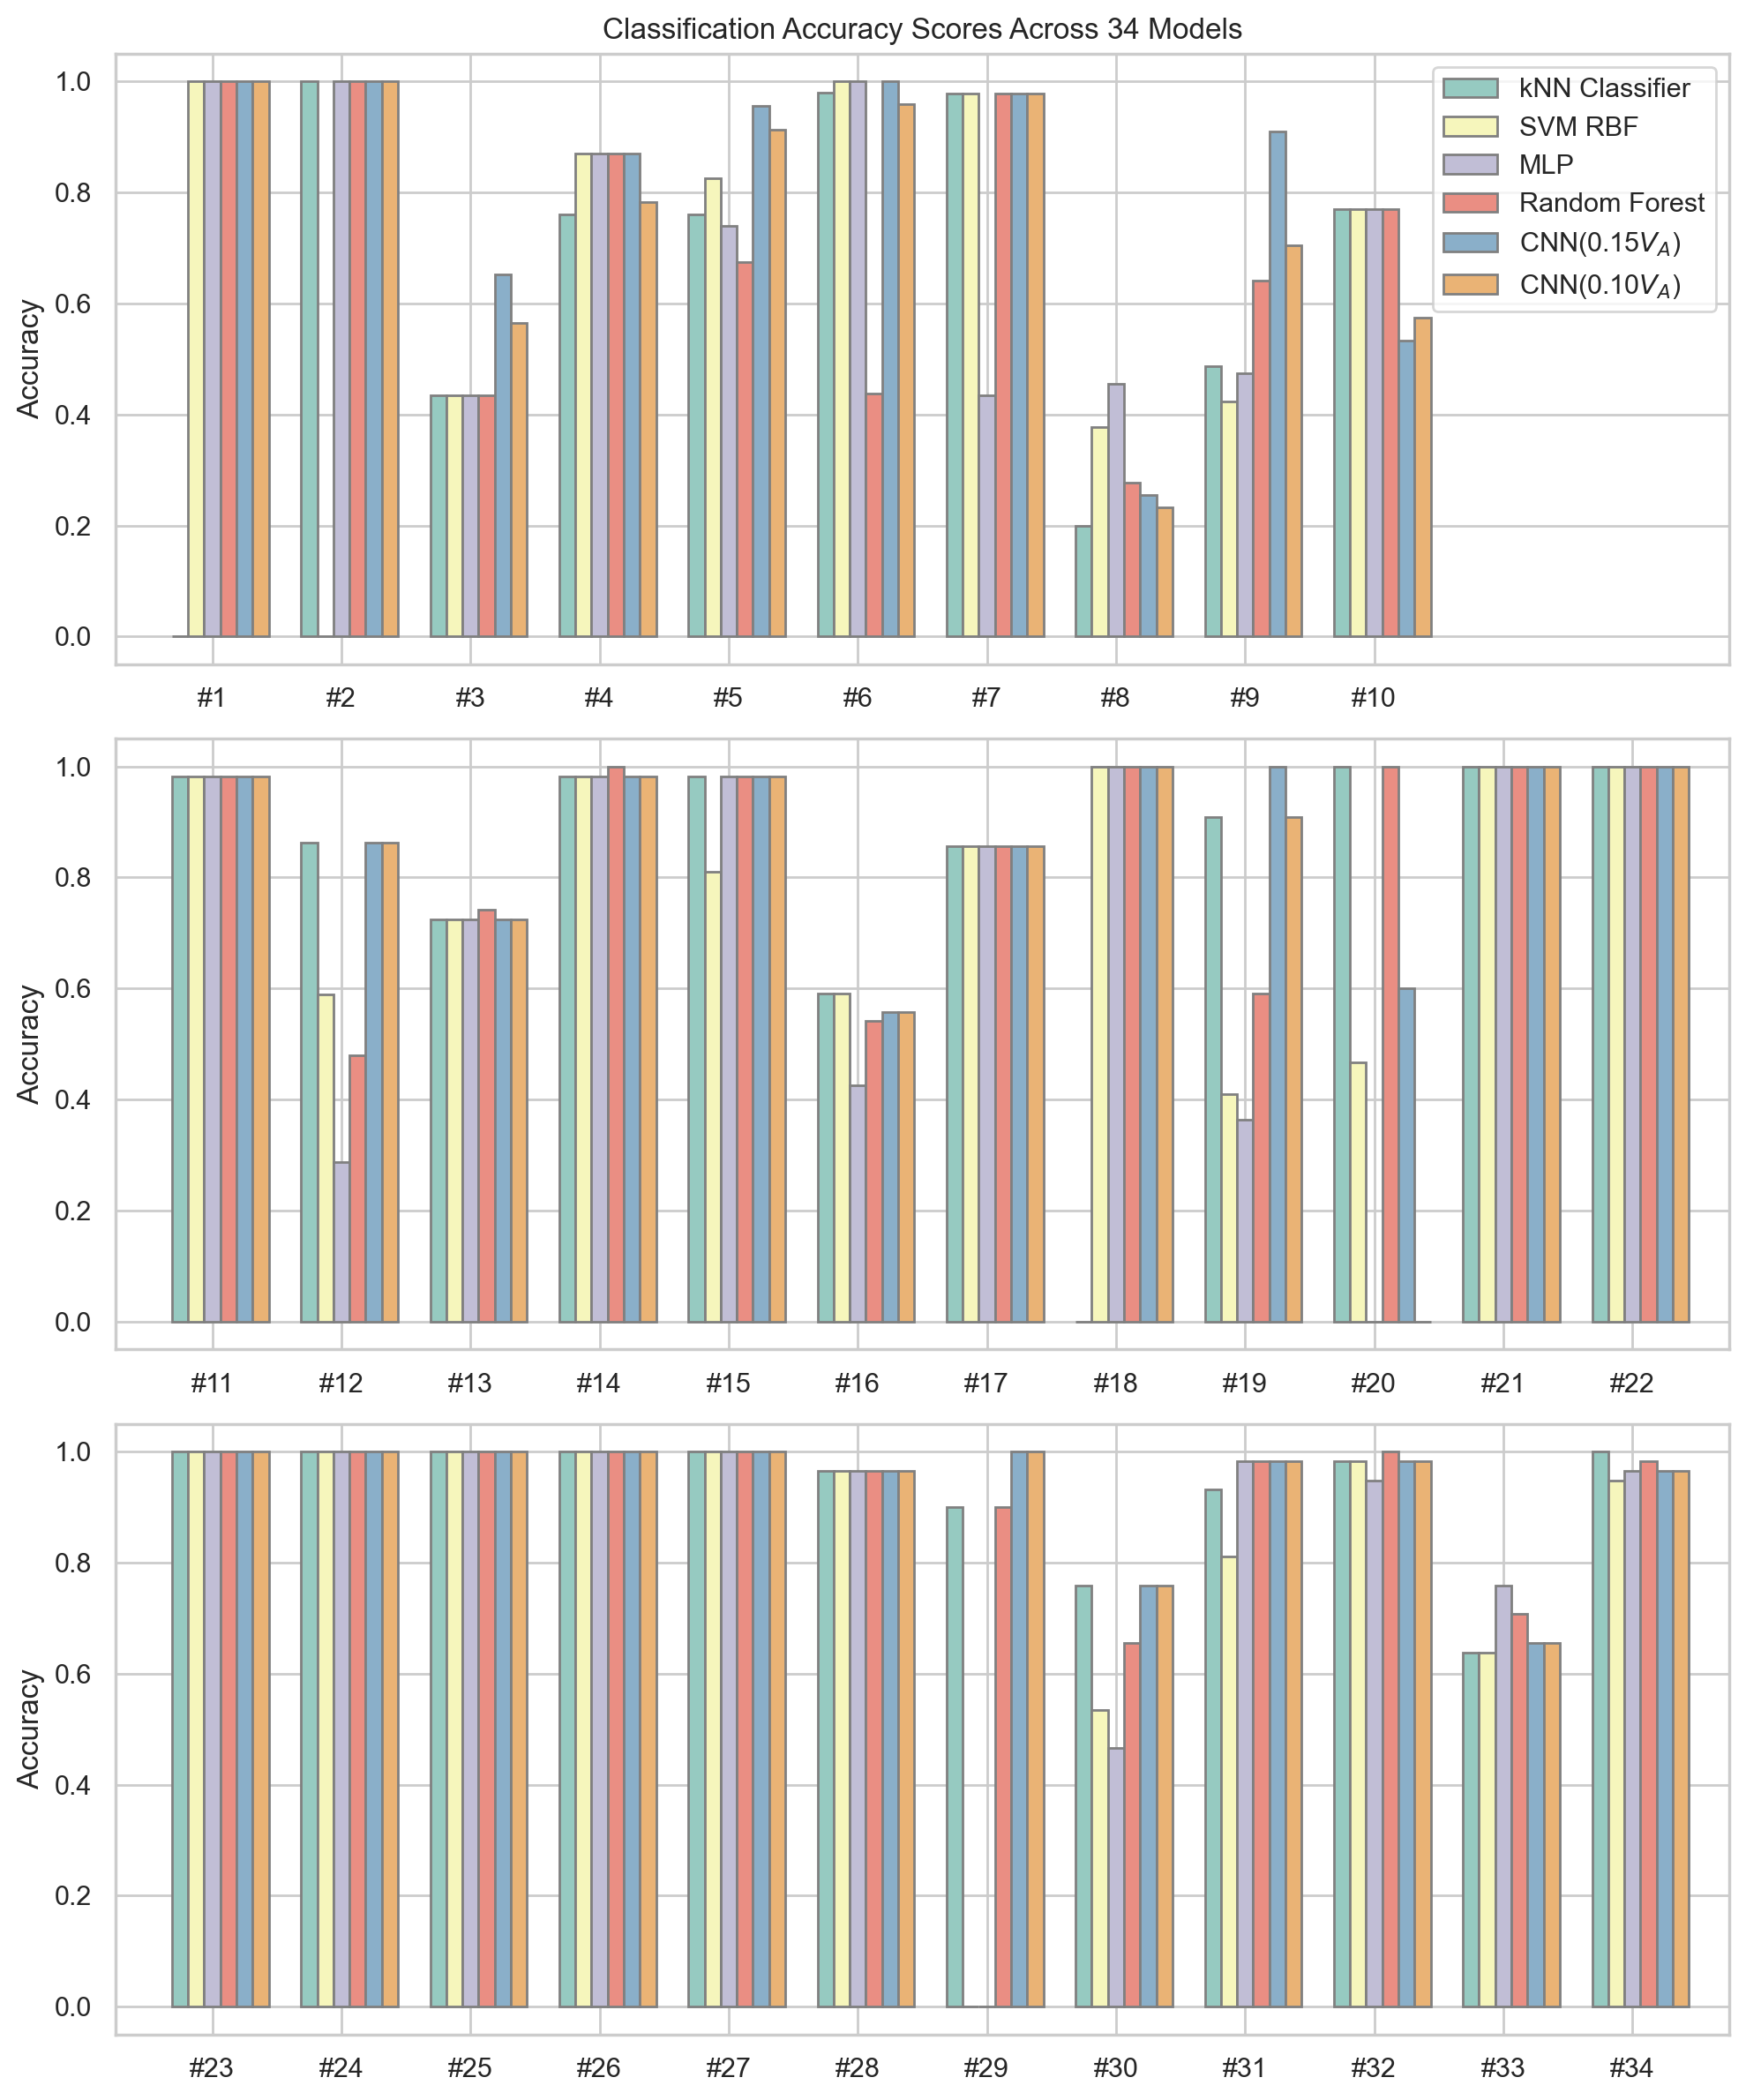

In [31]:
matplotlib.rcParams.update({'font.size':10})

modelnames = np.arange(1, 35)

# Set the bar width and positions
bar_width = 0.125
r1 = np.arange(len(modelnames))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]
r5 = [x + bar_width for x in r4]
r6 = [x + bar_width for x in r5]

im, ax = plt.subplots(3, 1, figsize=(10, 12), dpi=200)



# Plotting the bar chart
ax[0].bar(r1[0:10], accuracies_knn[0:10], bar_width, color='#96cac1', edgecolor='grey', label='kNN Classifier')
ax[0].bar(r2[0:10], accuracies_svm[0:10], bar_width, color='#f6f6bc', edgecolor='grey', label='SVM RBF')
ax[0].bar(r3[0:10], accuracies_mlp[0:10], bar_width, color='#c1bed6', edgecolor='grey', label='MLP')
ax[0].bar(r4[0:10], accuracies_rf[0:10], bar_width, color='#ea8e83', edgecolor='grey', label='Random Forest')
ax[0].bar(r5[0:10], accuracies_cnn15[0:10], bar_width, color='#8aafc9', edgecolor='grey', label=r'CNN(0.15$V_{A}$)')
ax[0].bar(r6[0:10], accuracies_cnn10[0:10], bar_width, color='#eab375', edgecolor='grey', label=r'CNN(0.10$V_{A}$)')

simfilelabels_simp = ['#1', '#2', '#3', '#4', '#5', '#6', '#7', '#8', '#9', '#10']

# Adding labels and title
ax[0].set(ylabel='Accuracy', title='Classification Accuracy Scores Across 34 Models', ylim=[-0.05,1.05], xlim=[-0.5,12])
ax[0].set_xticks([r + 2*bar_width for r in range(len(modelnames[:10]))])
ax[0].set_xticklabels(simfilelabels_simp)

# Adding legend
ax[0].legend()





ax[1].bar(r1[0:12], accuracies_knn[10:22], bar_width, color='#96cac1', edgecolor='grey', label='kNN Classifier')
ax[1].bar(r2[0:12], accuracies_svm[10:22], bar_width, color='#f6f6bc', edgecolor='grey', label='SVM RBF')
ax[1].bar(r3[0:12], accuracies_mlp[10:22], bar_width, color='#c1bed6', edgecolor='grey', label='MLP')
ax[1].bar(r4[0:12], accuracies_rf[10:22], bar_width, color='#ea8e83', edgecolor='grey', label='Random Forest')
ax[1].bar(r5[0:12], accuracies_cnn15[10:22], bar_width, color='#8aafc9', edgecolor='grey', label=r'CNN(0.15$V_{A}$)')
ax[1].bar(r6[0:12], accuracies_cnn10[10:22], bar_width, color='#eab375', edgecolor='grey', label=r'CNN(0.10$V_{A}$)')

simfilelabels_simp = ['#11', '#12', '#13', '#14', '#15', '#16', '#17', '#18', '#19', '#20', '#21', '#22']

# Adding labels and title
ax[1].set(ylabel='Accuracy', ylim=[-0.05,1.05], xlim=[-0.5,12])
ax[1].set_xticks([r + 2*bar_width for r in range(len(modelnames[:12]))])
ax[1].set_xticklabels(simfilelabels_simp)




ax[2].bar(r1[0:12], accuracies_knn[22:34], bar_width, color='#96cac1', edgecolor='grey', label='kNN Classifier')
ax[2].bar(r2[0:12], accuracies_svm[22:34], bar_width, color='#f6f6bc', edgecolor='grey', label='SVM RBF')
ax[2].bar(r3[0:12], accuracies_mlp[22:34], bar_width, color='#c1bed6', edgecolor='grey', label='MLP')
ax[2].bar(r4[0:12], accuracies_rf[22:34], bar_width, color='#ea8e83', edgecolor='grey', label='Random Forest')
ax[2].bar(r5[0:12], accuracies_cnn15[22:34], bar_width, color='#8aafc9', edgecolor='grey', label=r'CNN(0.15$V_{A}$)')
ax[2].bar(r6[0:12], accuracies_cnn10[22:34], bar_width, color='#eab375', edgecolor='grey', label=r'CNN(0.10$V_{A}$)')

simfilelabels_simp = ['#23', '#24', '#25', '#26', '#27', '#28', '#29', '#30', '#31', '#32', '#33', '#34']

# Adding labels and title
ax[2].set(ylabel='Accuracy', ylim=[-0.05,1.05], xlim=[-0.5,12])
ax[2].set_xticks([r + 2*bar_width for r in range(len(modelnames[:12]))])
ax[2].set_xticklabels(simfilelabels_simp)




plt.tight_layout()
plt.savefig('./visualizations_paper/accuracy_allmodels.png')
plt.show()

## Test 2. Understanding the parameter space

There are several actions that could be done here, including (1) understanding what simulation runs produce the largest number of incorrect predictions, and (2) figuring out where the incorrect predictions are on the 'Brazil' plot, for the beginnning, and (3) comparison of random forest with others.

In [12]:
def outputclass_indexes(test_labels, predicted_labels):
    indexes_tp = []
    indexes_tn = []
    indexes_fp = []
    indexes_fn = []
    for j in range (0, len(test_labels), 1):
        if ((test_labels[j] == 1) and (predicted_labels[j] == 1)): indexes_tp.append(j)
        if ((test_labels[j] == 0) and (predicted_labels[j] == 0)): indexes_tn.append(j)
        if ((test_labels[j] == 0) and (predicted_labels[j] == 1)): indexes_fp.append(j)
        if ((test_labels[j] == 1) and (predicted_labels[j] == 0)): indexes_fn.append(j)
    return indexes_tp, indexes_tn, indexes_fp, indexes_fn

In [15]:
featurevector_allmoments = np.load('./mldata_vdfmoments/allsimulations.featurevector_allmoments_all.npy')
times_allmoments = np.load('./mldata_vdfmoments/allsimulations.timep_array_all.npy')
labels_an = np.load('./mldata_vdfmoments/allsimulations.labels_allmoments_an_01_all.npy')
labels_me = np.load('./mldata_vdfmoments/allsimulations.labels_allmoments_me_01_all.npy')
simnames = np.load('./mldata_vdfmoments/allsimulations.simnames_all.npy')
# merging both labels
labels_allmoments = np.copy(labels_me)
labels_allmoments[np.where(labels_an == 1)] = 1

print('The total number of data points is: ' + str(len(labels_allmoments)))
print('Among them unstable (positive) samples: ' + str(len(np.where(labels_allmoments == 1)[0])))

scaler = StandardScaler()
scaler.fit(featurevector_allmoments)
featurevector_allmoments = scaler.transform(featurevector_allmoments)

The total number of data points is: 1596
Among them unstable (positive) samples: 418


In [16]:
simfiles = [\
'particles.d11_A0.5Hepp_beta0.5eps1e-4_256',\
'particles.d11_A0.75Hepp_beta1_256',\
'particles.d11_E11Ap3.3Aa2.0Vd0.42',\
'particles.d11_E11Ap4.3Aa1.6',\
'particles.d11_E11Ap4.3Aa1.6Vd0.32',\
'particles.d11_E12Ap1.86Aa1.0Vd0.32_512_256x256',\
'particles.d11_He++A10_256_iden0eps0',\
'particles.d11_He++v2_256_iden0eps1e-4t600',\
'particles.d11_He++vd1.5_256_iden0eps1e-4',\
'particles.d11_pv1.5_128_64_iden0eps1e-4_dx0.75_long',\
'particles.d11_pv1Ap2Apb2betac0.214betab0.858_128_128x2_dx0.75_t3000',\
'particles.d11_pv2a_128x3_iden0eps1e-4_dx0.75',\
'particles.d11_pv2Ap1Ab1betac0.429betab0.858_128_128x2_dx0.75_t3000',\
'particles.d11_pv2Ap1Ab2betac0.429betab0.858_128_128x2_dx0.75_t3000',\
'particles.d11_pv2Ap2Apb2betac0.214betab0.858_128_128x2_dx0.75_t3000',\
'particles.d11_pv2av2.3_128x3_iden0eps1e-4_dx0.75',\
'particles.d11_pv2av2_rdna0.03375_128x3_iden0eps1e-4_dx0.75_t6000',\
'particles.d11_vap1.2Ap1Aa0.75_rdna_0.05',\
'particles.d11_vap1.2Ap3.35Aa2.05rdna_0.007',\
'particles.d11_vap1.5Ap1.5Aa1rdna_0.007',\
'particles.d11_e260945ap1.30.5_1',\
'particles.d11_e260955ap2.20.4_2',\
'particles.d11_e261013ap1.50.6_3',\
'particles.d11_e261016ap1.70.6_4',\
'particles.d11_e261019ap1.50.4_5',\
'particles.d11_e261022ap1.40.4_6',\
'particles.d11_e261040ap1.40.4_7',\
'particles.d11_pv1.4av2Ap2Apb2betac0.214betab0.858_128_128x4_dx0.75',\
'particles.d11_pv2Ap2Apb2beta_pb0.429_128_128x2_dx0.75',\
'particles.d11_pv2av1.4Ap1Aa1betac0.214betab0.858_128_128x4_dx0.75',\
'particles.d11_pv2av1.4Ap2Aa2betac0.214betab0.858_128_128x4_dx0.75',\
'particles.d11_pv2av1.4Ap2Ab2beta0.429_128_128x4_dx0.75_t3000',\
'particles.d11_pv2av2Ap1Aa1beta0.429_128_128x4_dx0.75_t3000',\
'particles.d11_pv2av2Ap2Aa2beta0.429_128_128x4_dx0.75_t3000']

### Visualizations for separate runs
- featurevector_allmoments[:,16] - proton anisotropy
- featurevector_allmoments[:,2] - proton beta ||
- featurevector_allmoments[:,0] - proton velocity
- featurevector_allmoments[:,17] - alpha anisotropy
- featurevector_allmoments[:,10] - alpha beta ||
- featurevector_allmoments[:,8] - alpha velocity
- featurevector_allmoments[:,18] - proton abundance
- featurevector_allmoments[:,19] - alpha abundance

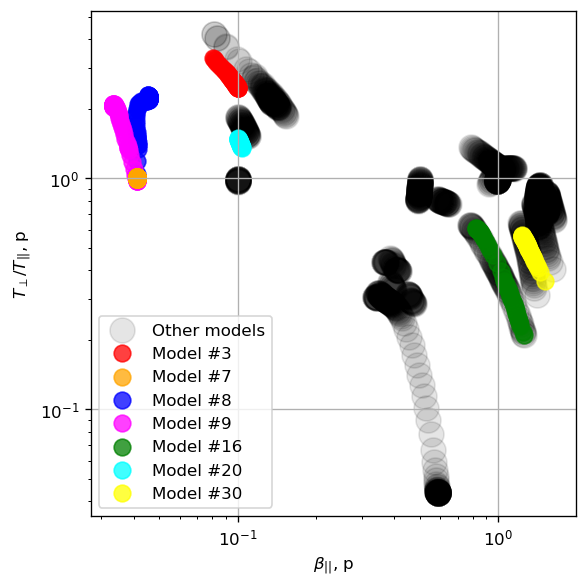

In [48]:
featurevector_allmoments = np.load('./mldata_vdfmoments/allsimulations.featurevector_allmoments_all.npy')
p_be = featurevector_allmoments[:,2]
p_an = featurevector_allmoments[:,16]

matplotlib.rcParams.update({'font.size':10})

im, ax = plt.subplots(1, 1, figsize=(5,5), dpi=120)

plt.grid(True)

for nm, simfile in enumerate(simfiles):
    test_index = np.where(simnames == simfile)[0]
    if (nm == 0):
        ax.scatter(p_be[test_index], p_an[test_index], color='black', alpha=0.10, label='Other runs', s=225)
        continue
    if (nm not in [2, 6, 7, 8, 15, 19, 29]): ax.scatter(p_be[test_index], p_an[test_index], color='black', alpha=0.10, s=225)

for nm, simfile in enumerate(simfiles):
    test_index = np.where(simnames == simfile)[0]
    if (nm == 2): ax.scatter(p_be[test_index], p_an[test_index], color='red', alpha=0.75, label='Run #3', s=100)
    if (nm == 6): ax.scatter(p_be[test_index], p_an[test_index], color='orange', alpha=0.75, label='Run #7', s=100)
    if (nm == 7): ax.scatter(p_be[test_index], p_an[test_index], color='blue', alpha=0.75, label='Run #8', s=100)
    if (nm == 8): ax.scatter(p_be[test_index], p_an[test_index], color='magenta', alpha=0.75, label='Model #9', s=100)
    if (nm == 15): ax.scatter(p_be[test_index], p_an[test_index], color='green', alpha=0.75, label='Model #16', s=100)
    if (nm == 19): ax.scatter(p_be[test_index], p_an[test_index], color='cyan', alpha=0.75, label='Model #20', s=100)
    if (nm == 29): ax.scatter(p_be[test_index], p_an[test_index], color='yellow', alpha=0.75, label='Model #30', s=100)

for nm, simfile in enumerate(simfiles):
    test_index = np.where(simnames == simfile)[0]
    if (nm == 6): ax.scatter(p_be[test_index], p_an[test_index], color='orange', alpha=0.75, s=100)

ax.set(xscale='log', yscale='log', xlabel=r'$\beta{}_{||}$, p', ylabel=r'$T_{\perp}/T_{||}$, p')
ax.legend()

plt.tight_layout()
plt.savefig('./visualizations_paper/parameterspace_models_sp1.png')
plt.show()

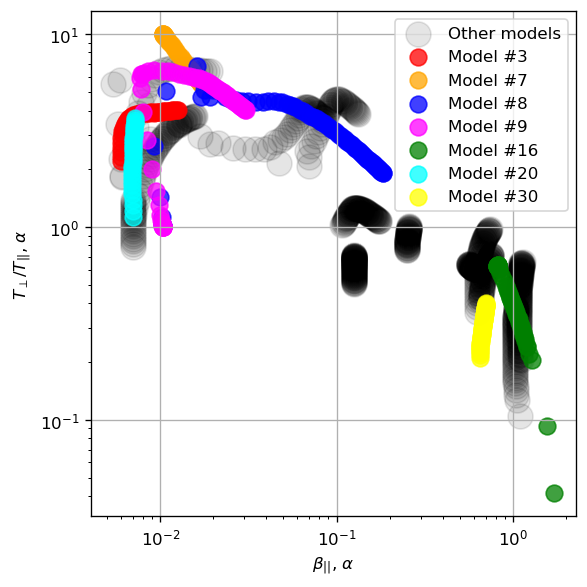

In [46]:
featurevector_allmoments = np.load('./mldata_vdfmoments/allsimulations.featurevector_allmoments_all.npy')
p_be = featurevector_allmoments[:,10]
p_an = featurevector_allmoments[:,17]

matplotlib.rcParams.update({'font.size':10})

im, ax = plt.subplots(1, 1, figsize=(5,5), dpi=120)

plt.grid(True)

for nm, simfile in enumerate(simfiles):
    test_index = np.where(simnames == simfile)[0]
    if (nm == 0):
        ax.scatter(p_be[test_index], p_an[test_index], color='black', alpha=0.10, label='Other models', s=225)
        continue
    if (nm not in [2, 6, 7, 8, 15, 19, 29]): ax.scatter(p_be[test_index], p_an[test_index], color='black', alpha=0.10, s=225)

for nm, simfile in enumerate(simfiles):
    test_index = np.where(simnames == simfile)[0]
    if (nm == 2): ax.scatter(p_be[test_index], p_an[test_index], color='red', alpha=0.75, label='Model #3', s=100)
    if (nm == 6): ax.scatter(p_be[test_index], p_an[test_index], color='orange', alpha=0.75, label='Model #7', s=100)
    if (nm == 7): ax.scatter(p_be[test_index], p_an[test_index], color='blue', alpha=0.75, label='Model #8', s=100)
    if (nm == 8): ax.scatter(p_be[test_index], p_an[test_index], color='magenta', alpha=0.75, label='Model #9', s=100)
    if (nm == 15): ax.scatter(p_be[test_index], p_an[test_index], color='green', alpha=0.75, label='Model #16', s=100)
    if (nm == 19): ax.scatter(p_be[test_index], p_an[test_index], color='cyan', alpha=0.75, label='Model #20', s=100)
    if (nm == 29): ax.scatter(p_be[test_index], p_an[test_index], color='yellow', alpha=0.75, label='Model #30', s=100)

ax.set(xscale='log', yscale='log', xlabel=r'$\beta{}_{||}$, $\alpha$', ylabel=r'$T_{\perp}/T_{||}$, $\alpha$')
ax.legend()

plt.tight_layout()
plt.savefig('./visualizations_paper/parameterspace_models_sp2.png')
plt.show()

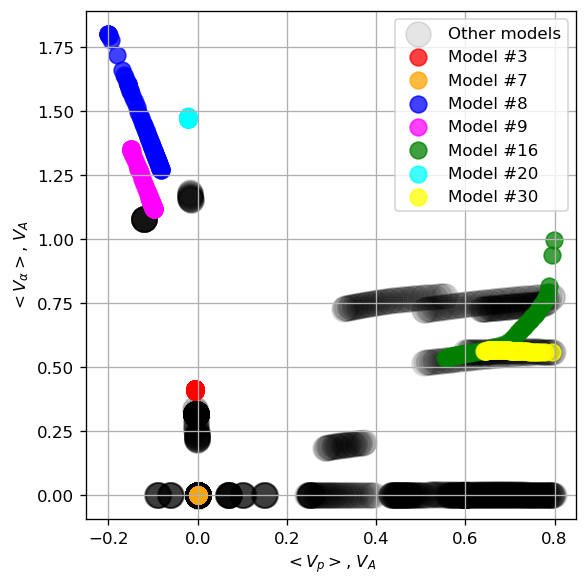

In [47]:
featurevector_allmoments = np.load('./mldata_vdfmoments/allsimulations.featurevector_allmoments_all.npy')
p_be = featurevector_allmoments[:,0]
p_an = featurevector_allmoments[:,8]

matplotlib.rcParams.update({'font.size':10})

im, ax = plt.subplots(1, 1, figsize=(5,5), dpi=120)

plt.grid(True)

for nm, simfile in enumerate(simfiles):
    test_index = np.where(simnames == simfile)[0]
    if (nm == 0):
        ax.scatter(p_be[test_index], p_an[test_index], color='black', alpha=0.10, label='Other models', s=225)
        continue
    if (nm not in [2, 6, 7, 8, 15, 19, 29]): ax.scatter(p_be[test_index], p_an[test_index], color='black', alpha=0.10, s=225)

for nm, simfile in enumerate(simfiles):
    test_index = np.where(simnames == simfile)[0]
    if (nm == 2): ax.scatter(p_be[test_index], p_an[test_index], color='red', alpha=0.75, label='Model #3', s=100)
    if (nm == 6): ax.scatter(p_be[test_index], p_an[test_index], color='orange', alpha=0.75, label='Model #7', s=100)
    if (nm == 7): ax.scatter(p_be[test_index], p_an[test_index], color='blue', alpha=0.75, label='Model #8', s=100)
    if (nm == 8): ax.scatter(p_be[test_index], p_an[test_index], color='magenta', alpha=0.75, label='Model #9', s=100)
    if (nm == 15): ax.scatter(p_be[test_index], p_an[test_index], color='green', alpha=0.75, label='Model #16', s=100)
    if (nm == 19): ax.scatter(p_be[test_index], p_an[test_index], color='cyan', alpha=0.75, label='Model #20', s=100)
    if (nm == 29): ax.scatter(p_be[test_index], p_an[test_index], color='yellow', alpha=0.75, label='Model #30', s=100)

ax.set(xlabel=r'$<V_{p}>$, $V_{A}$', ylabel=r'$<V_{\alpha}>$, $V_{A}$')
ax.legend()

plt.tight_layout()
plt.savefig('./visualizations_paper/parameterspace_models_sp3.png')
plt.show()

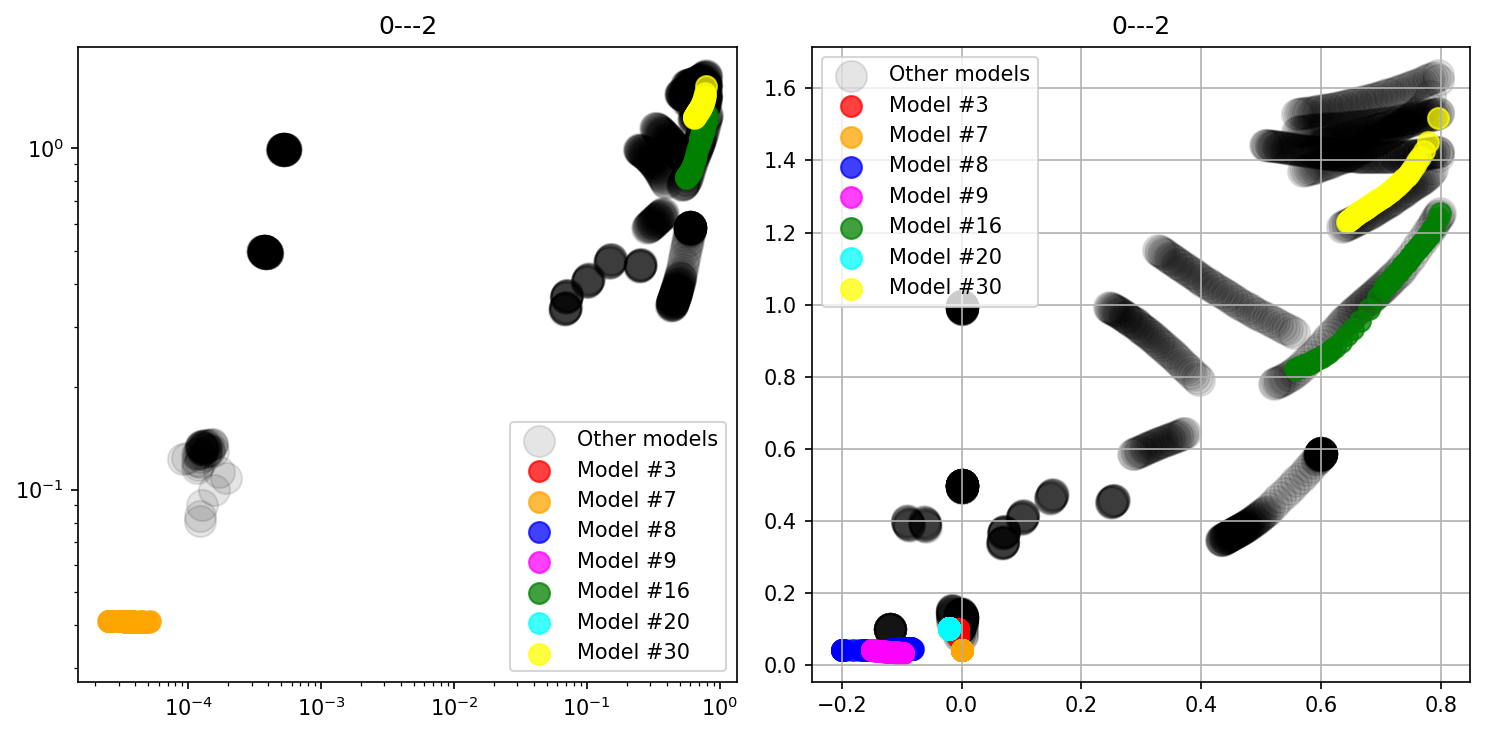

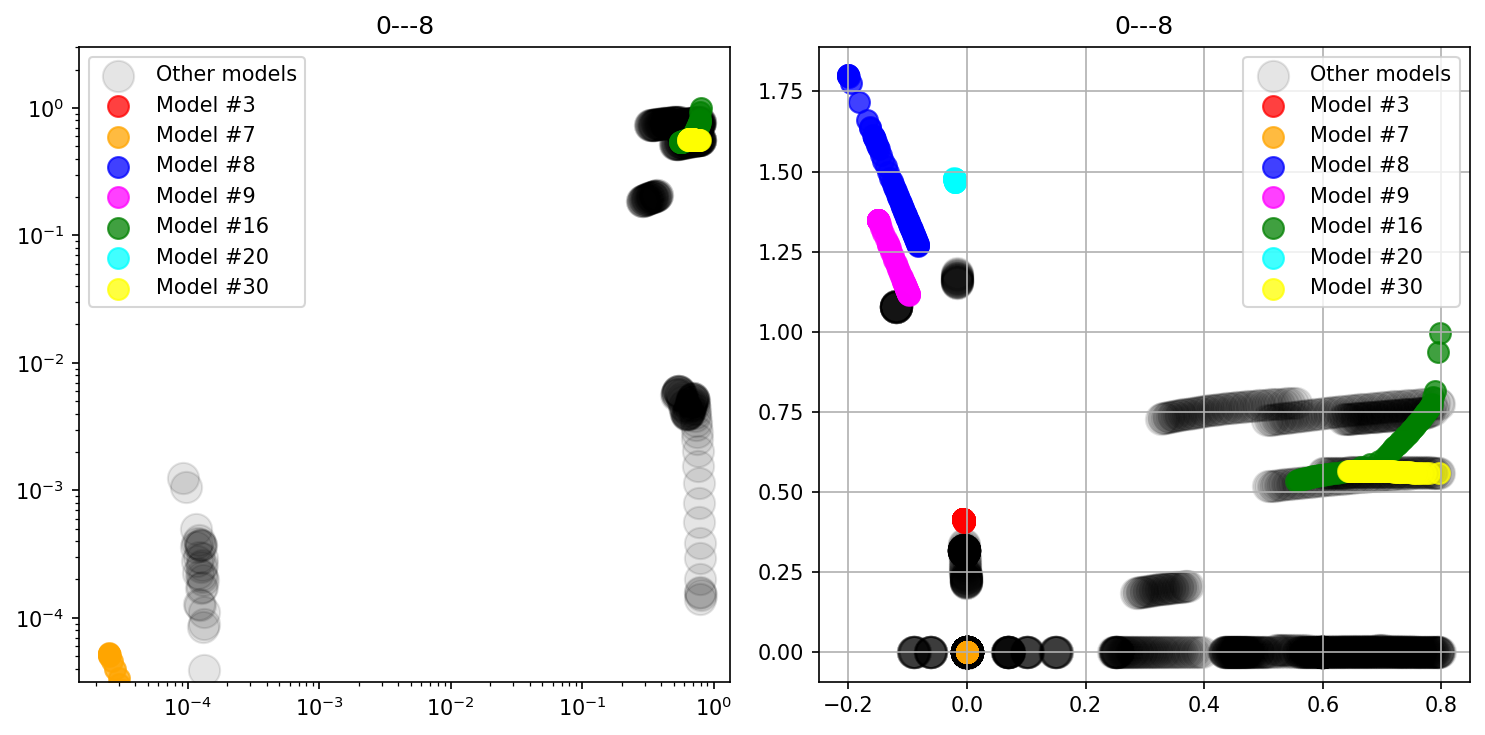

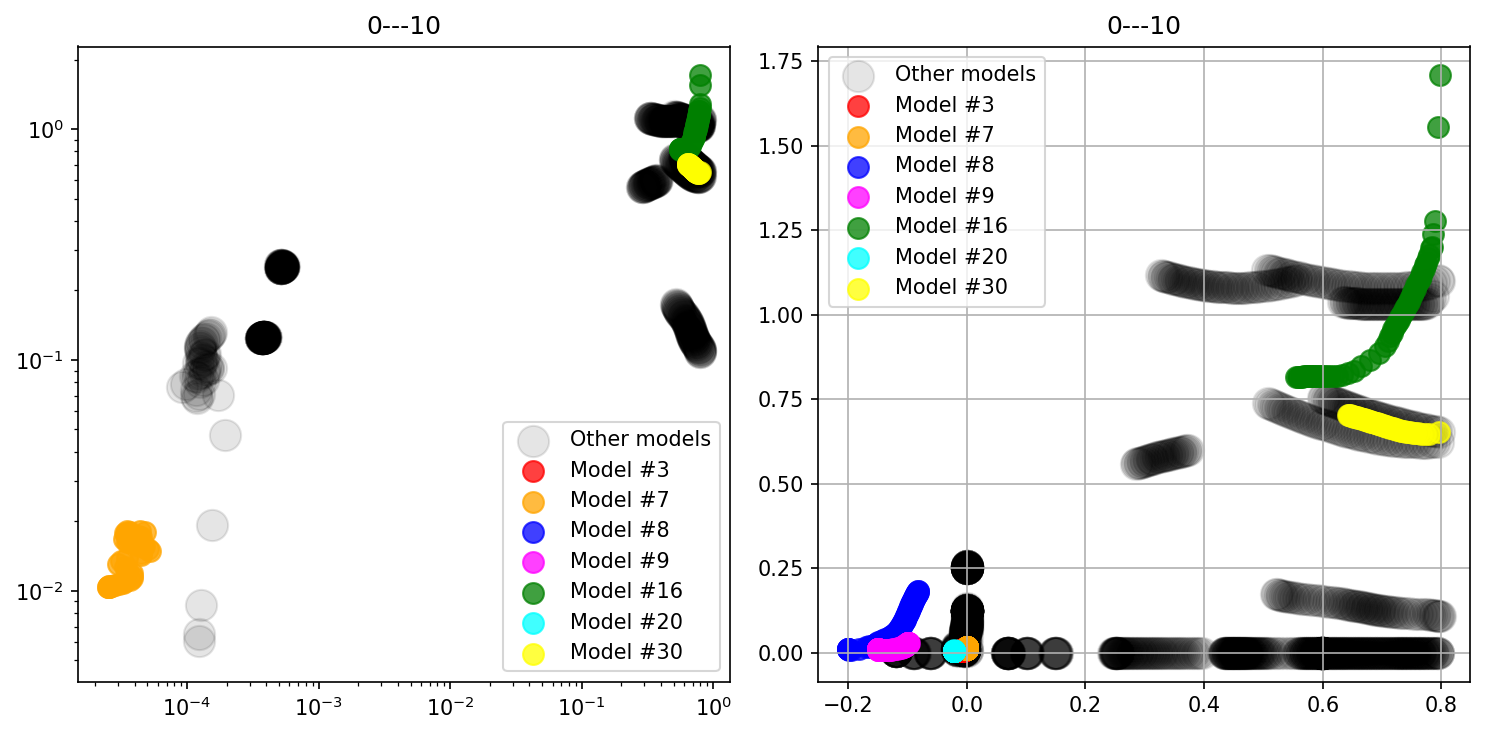

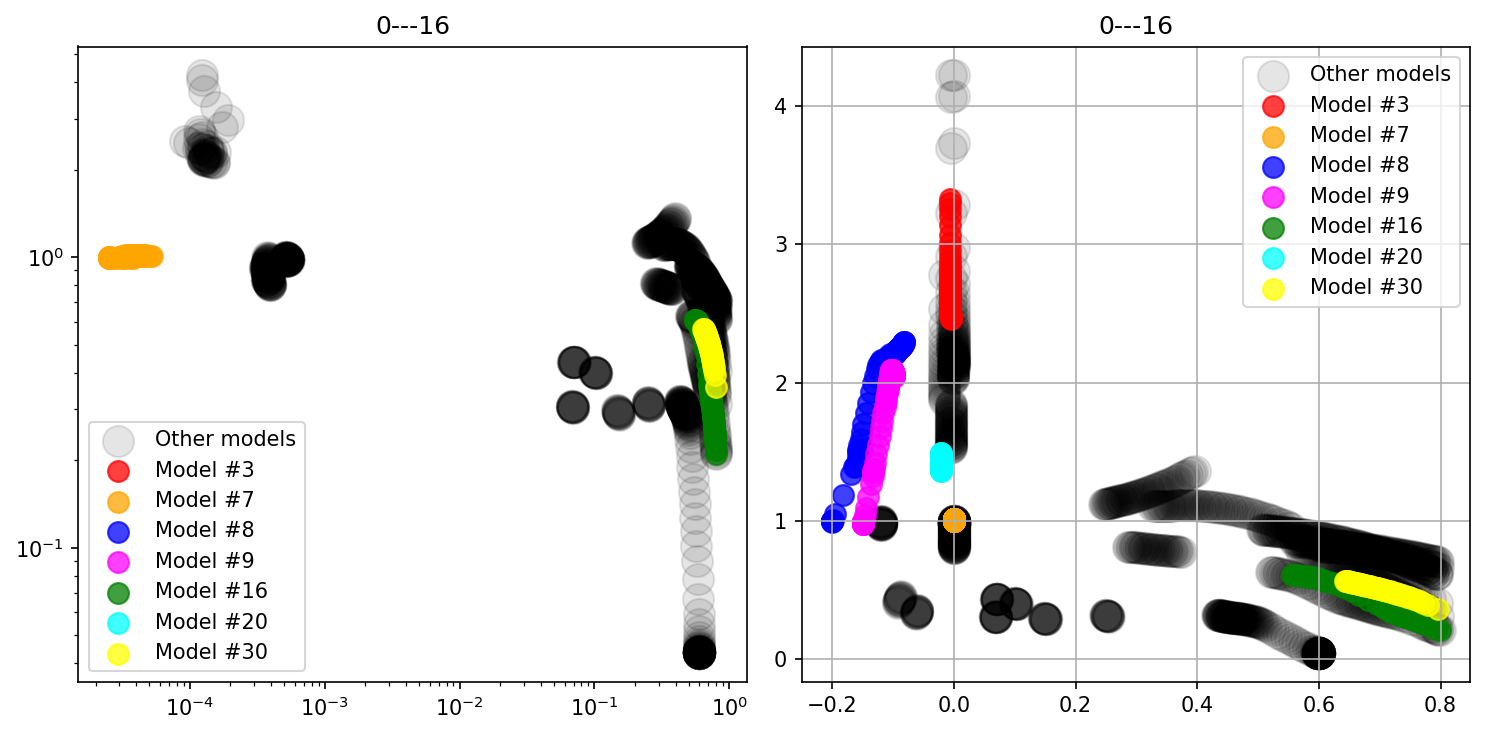

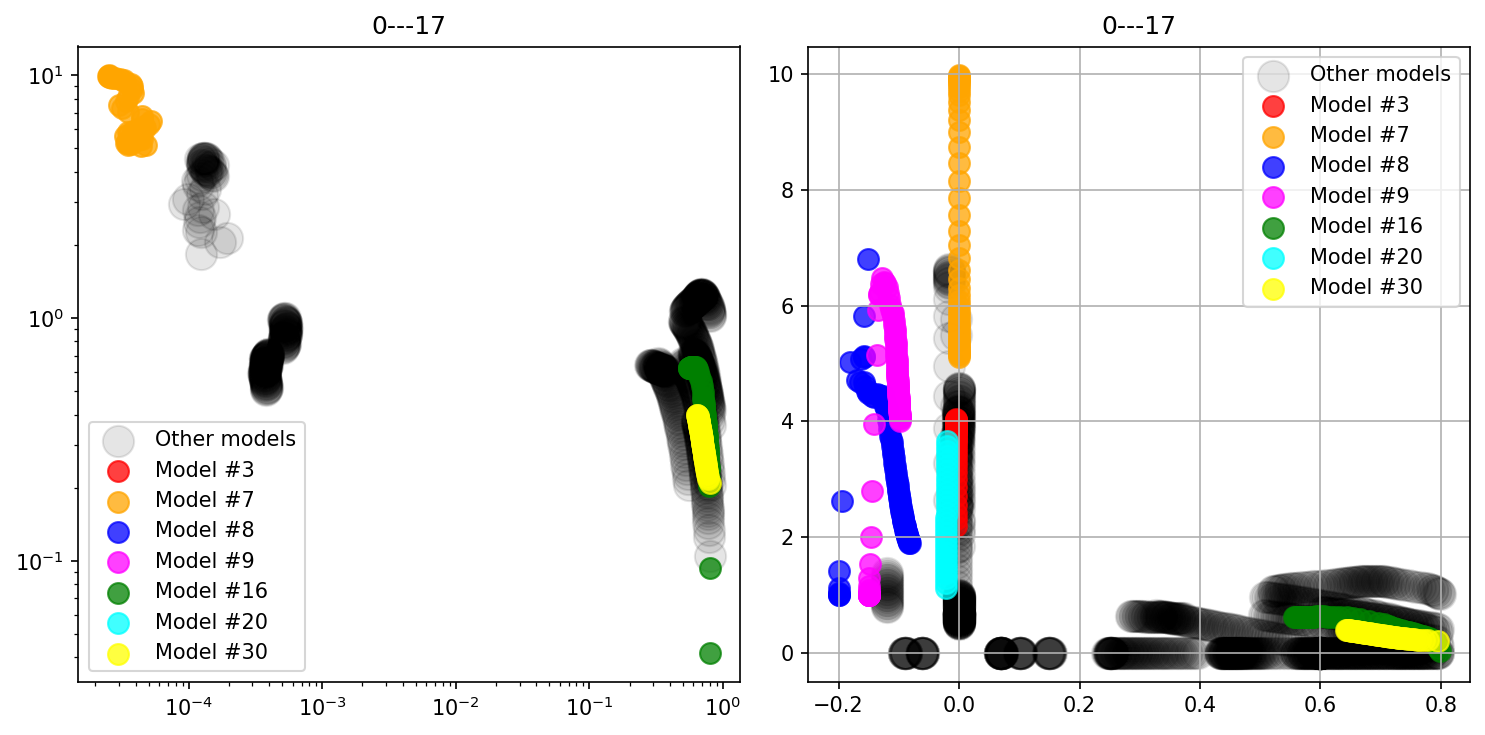

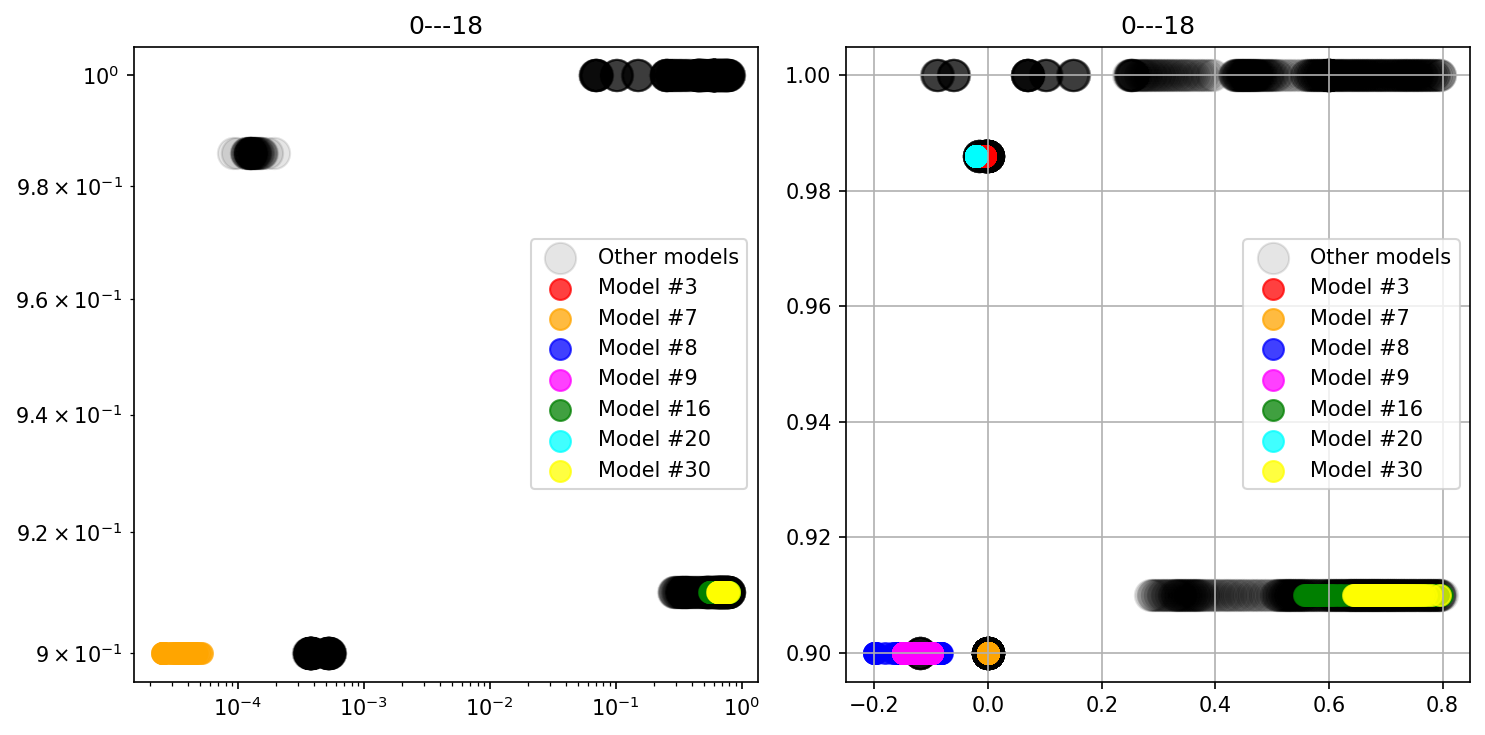

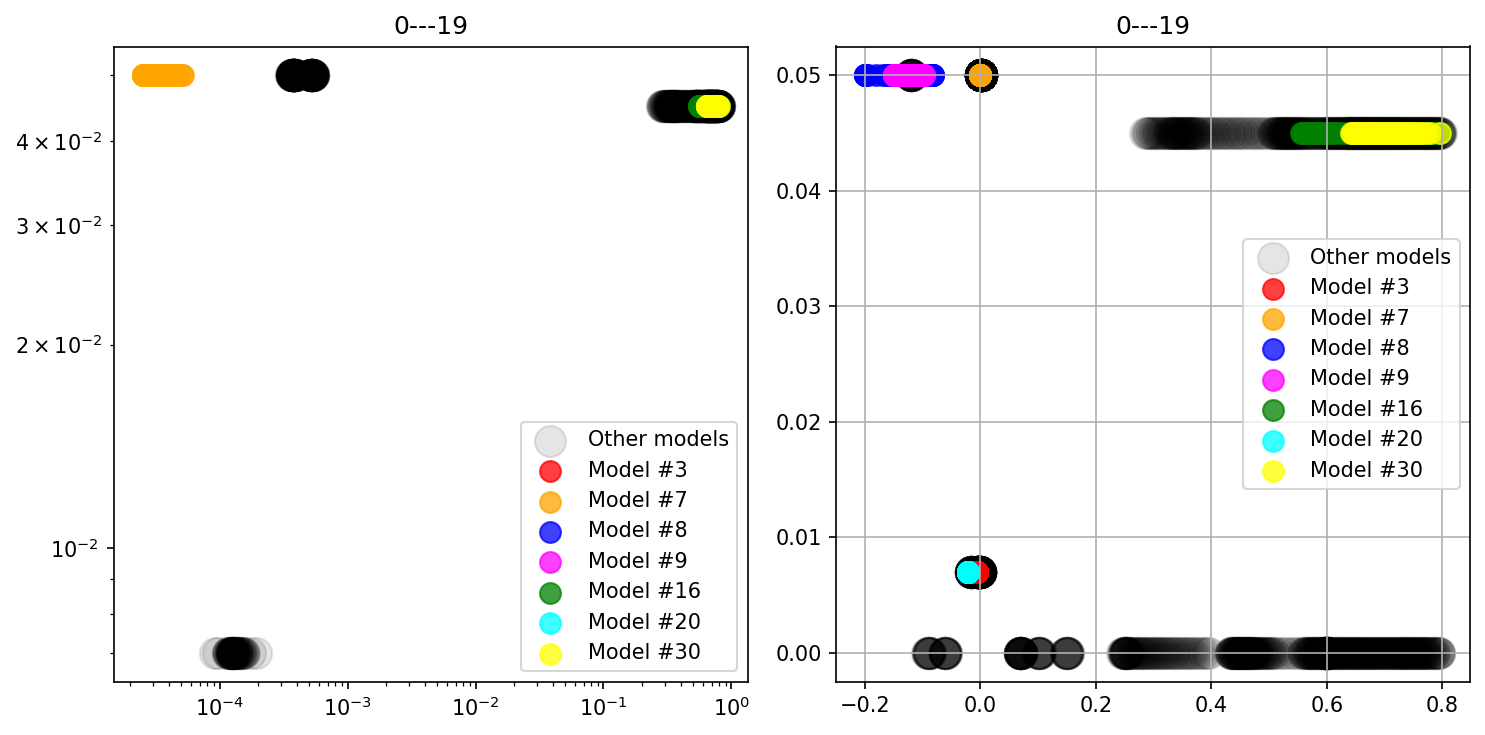

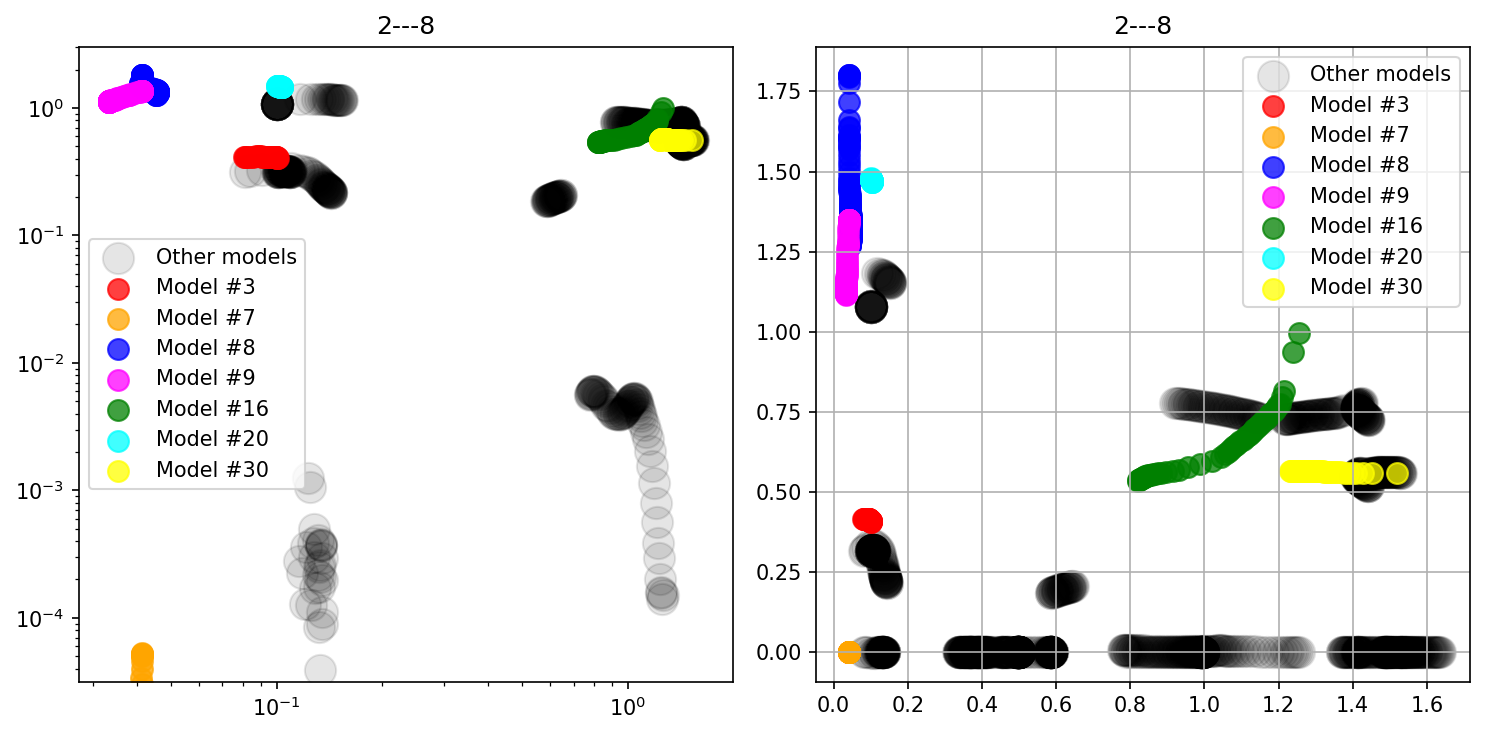

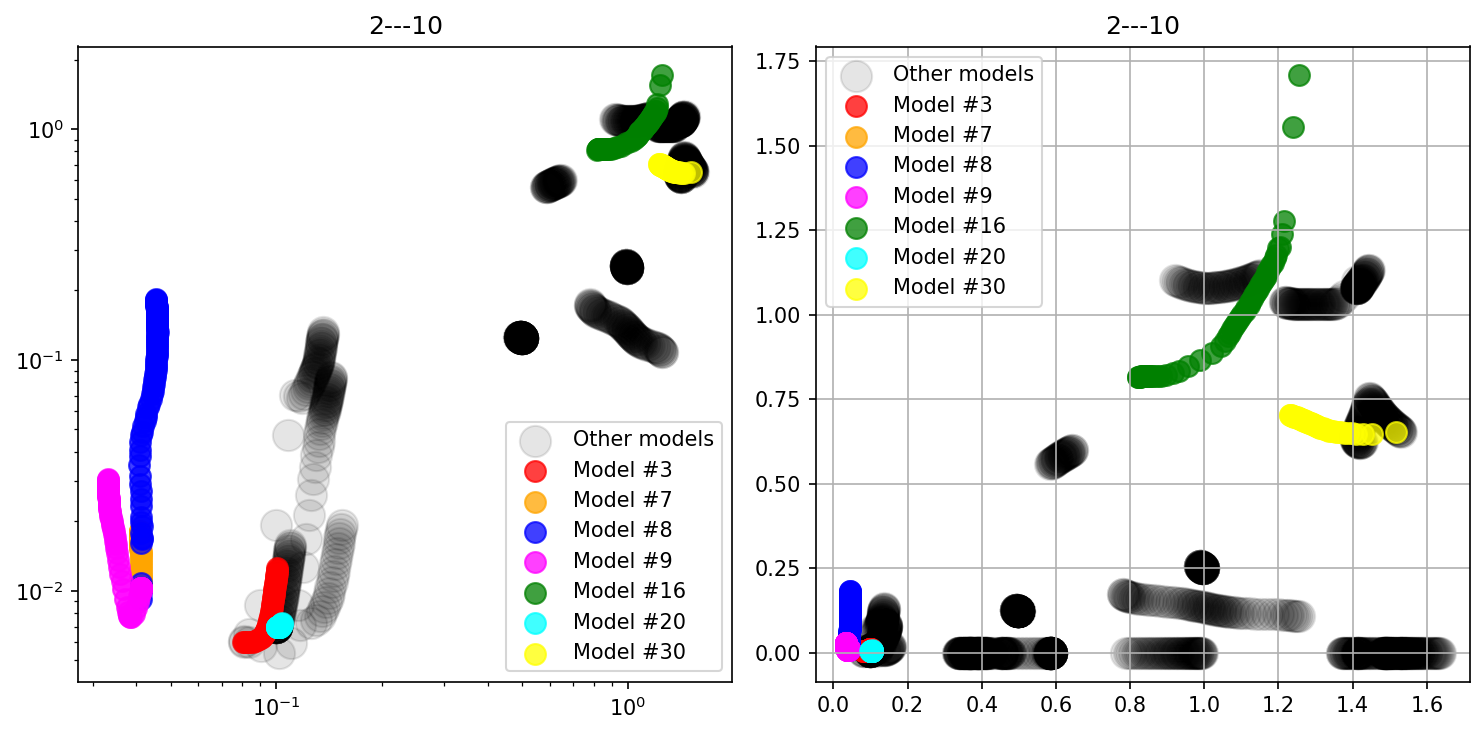

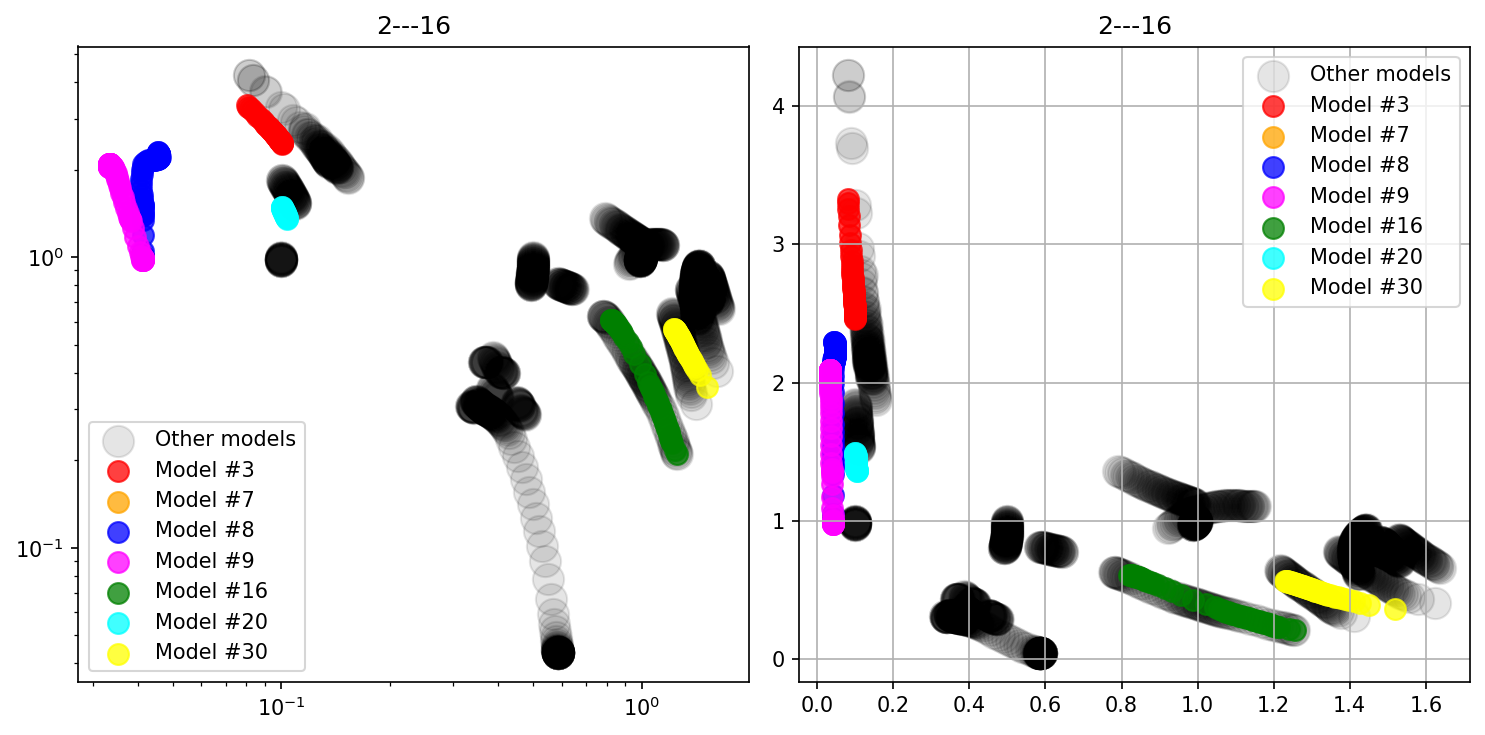

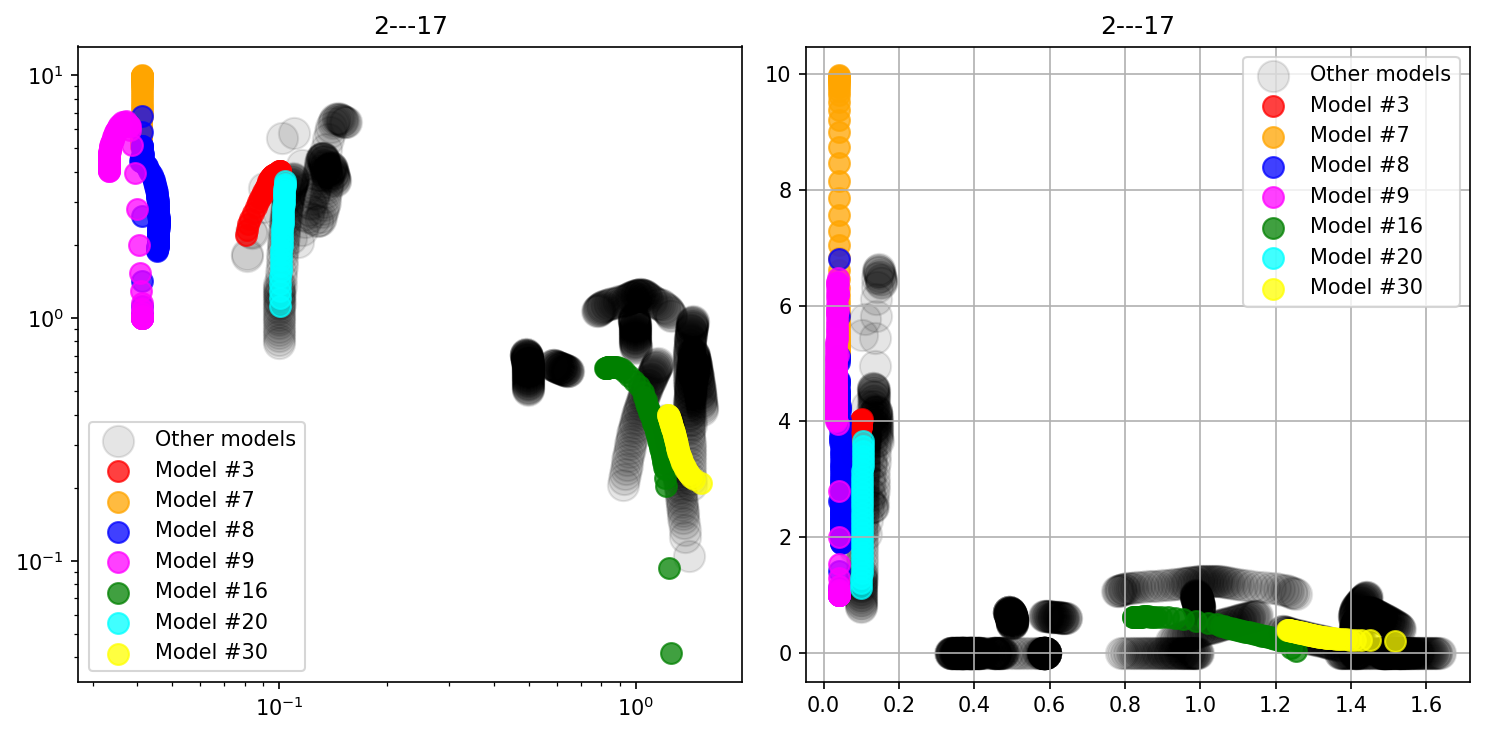

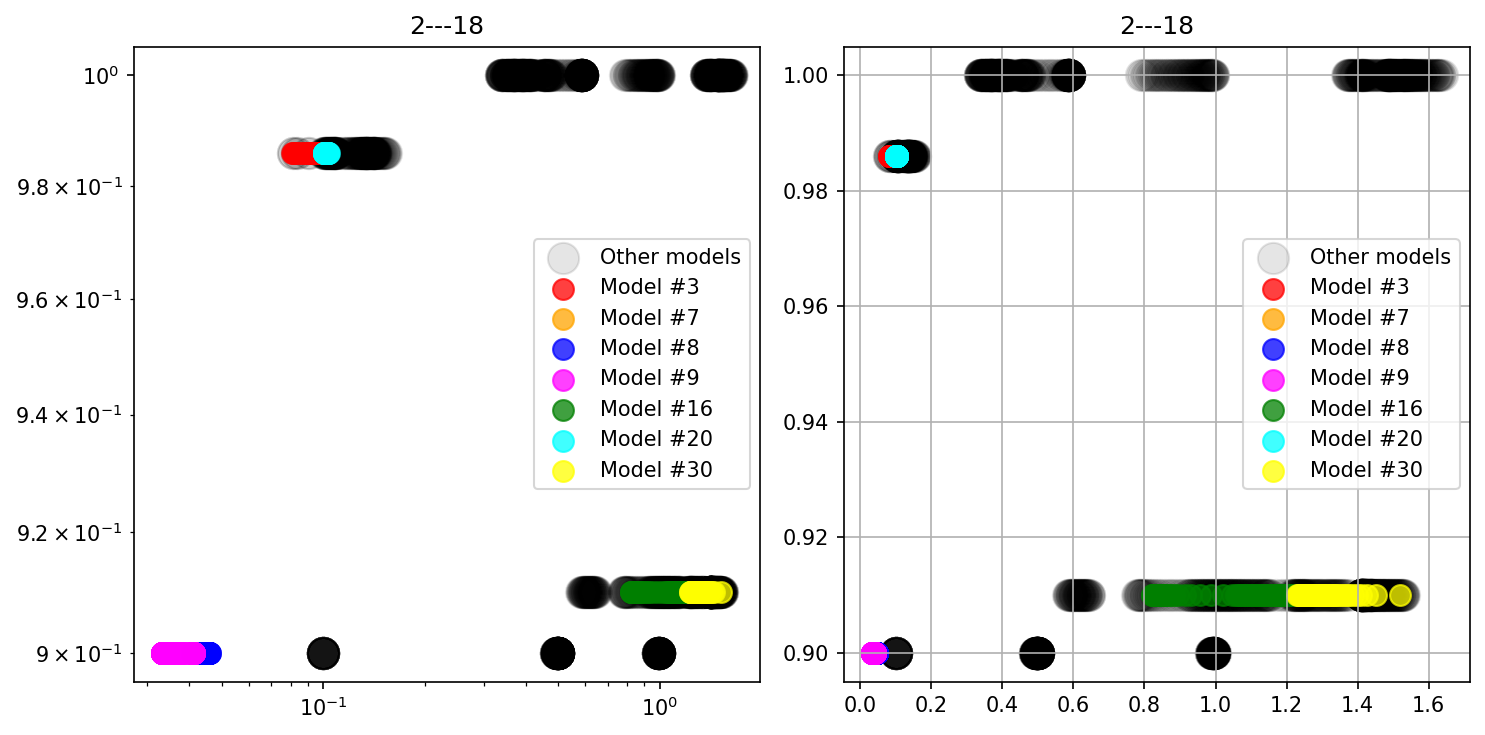

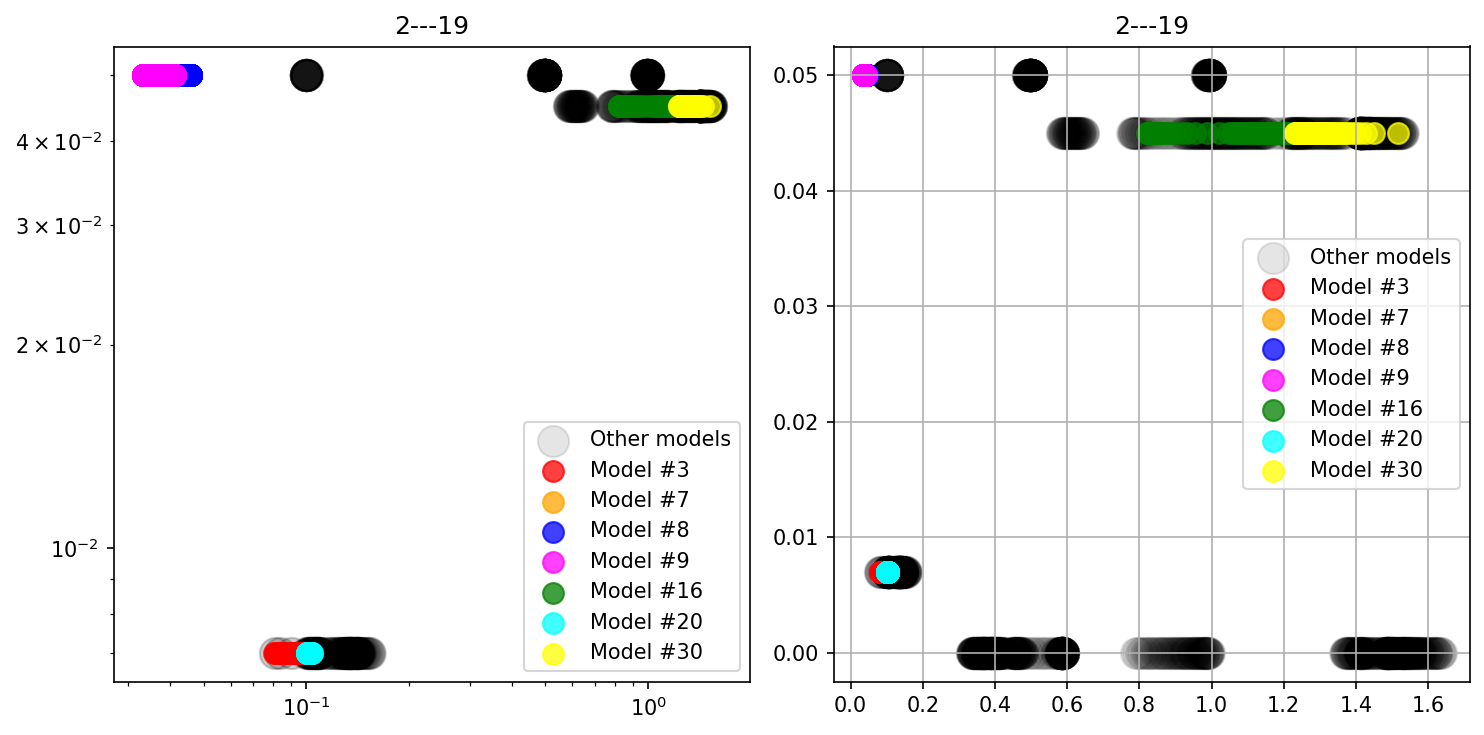

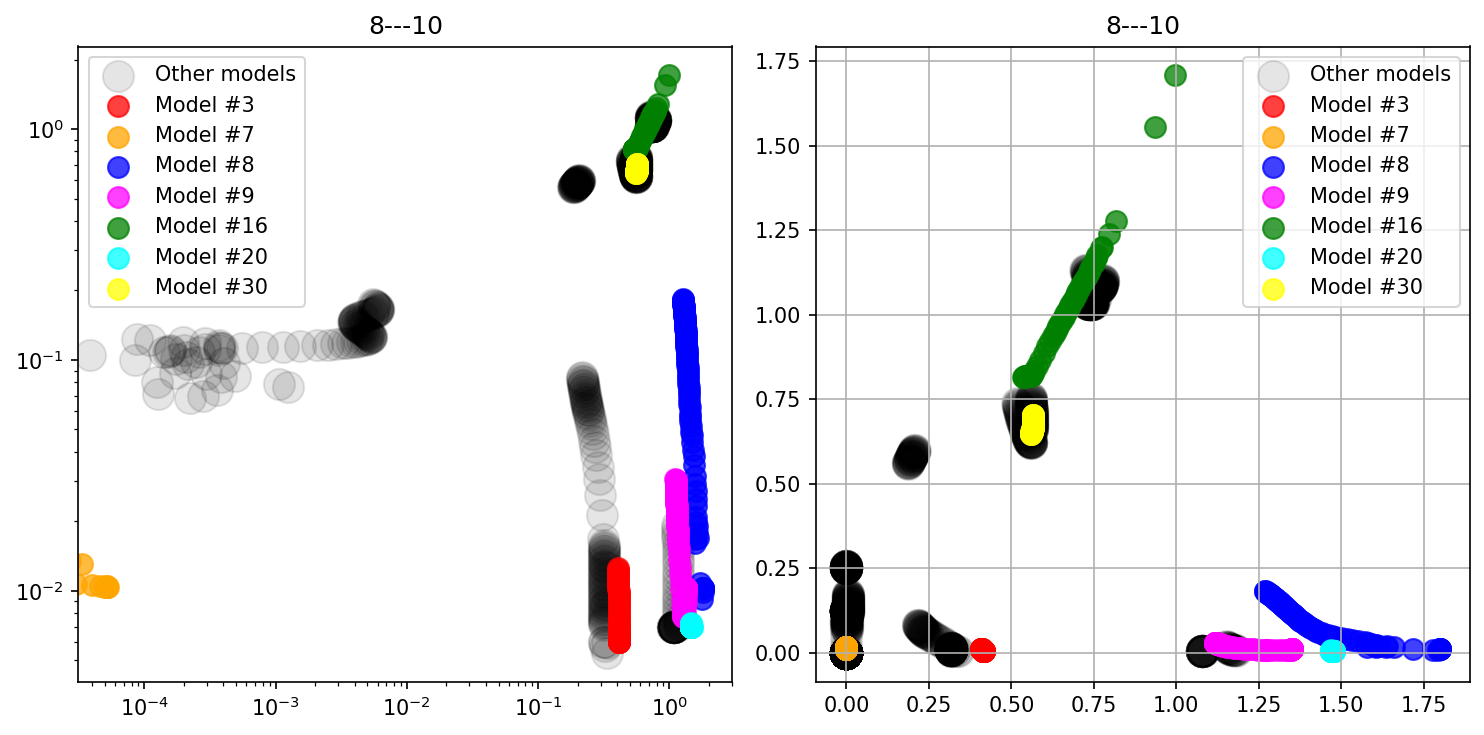

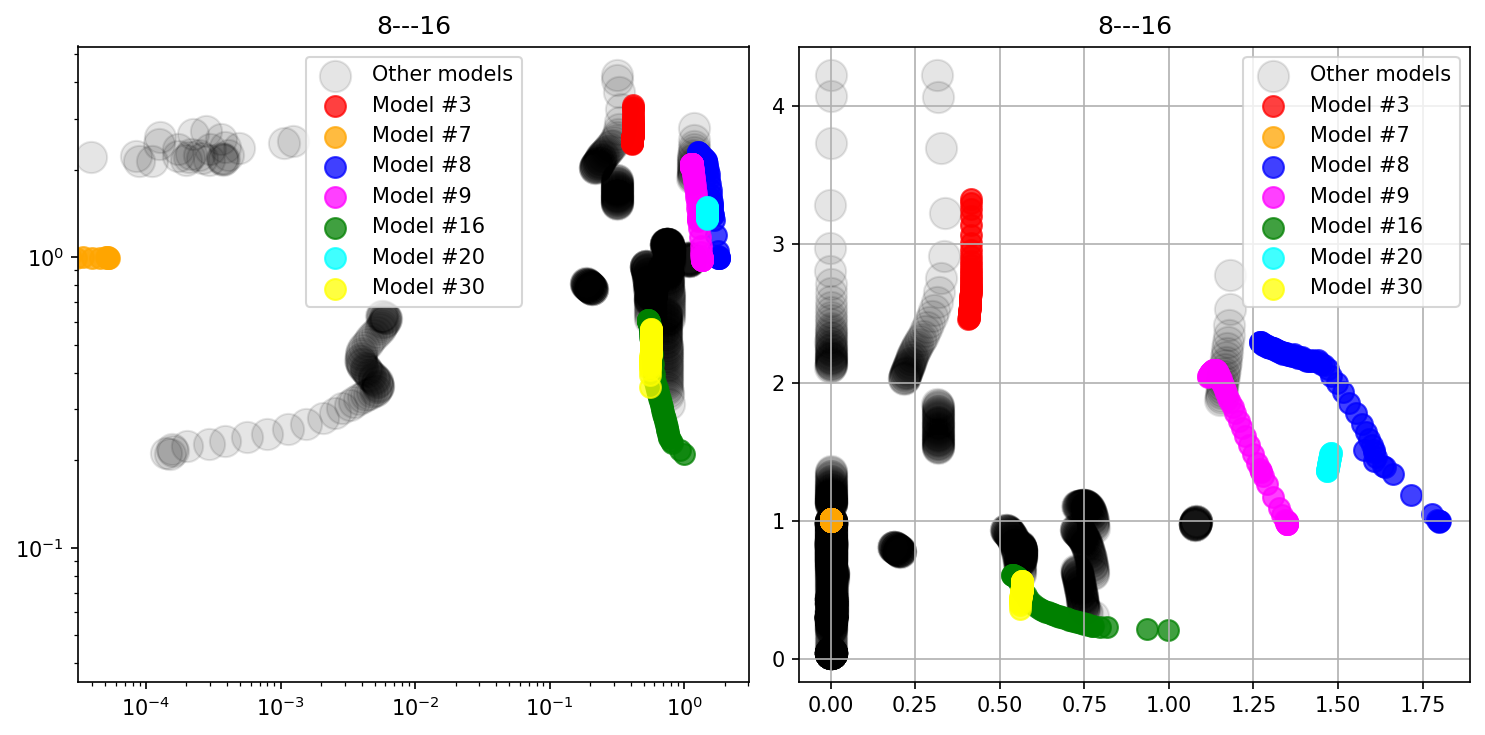

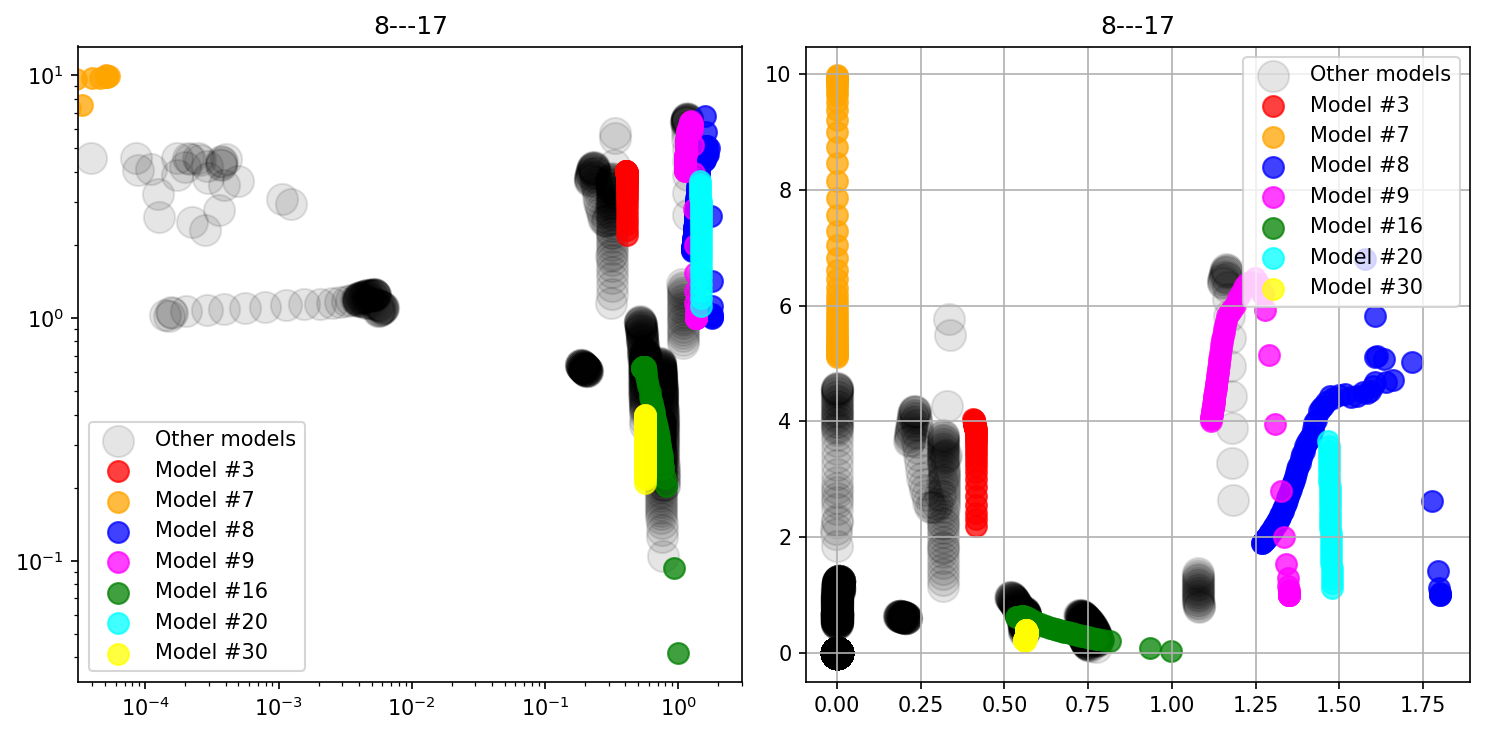

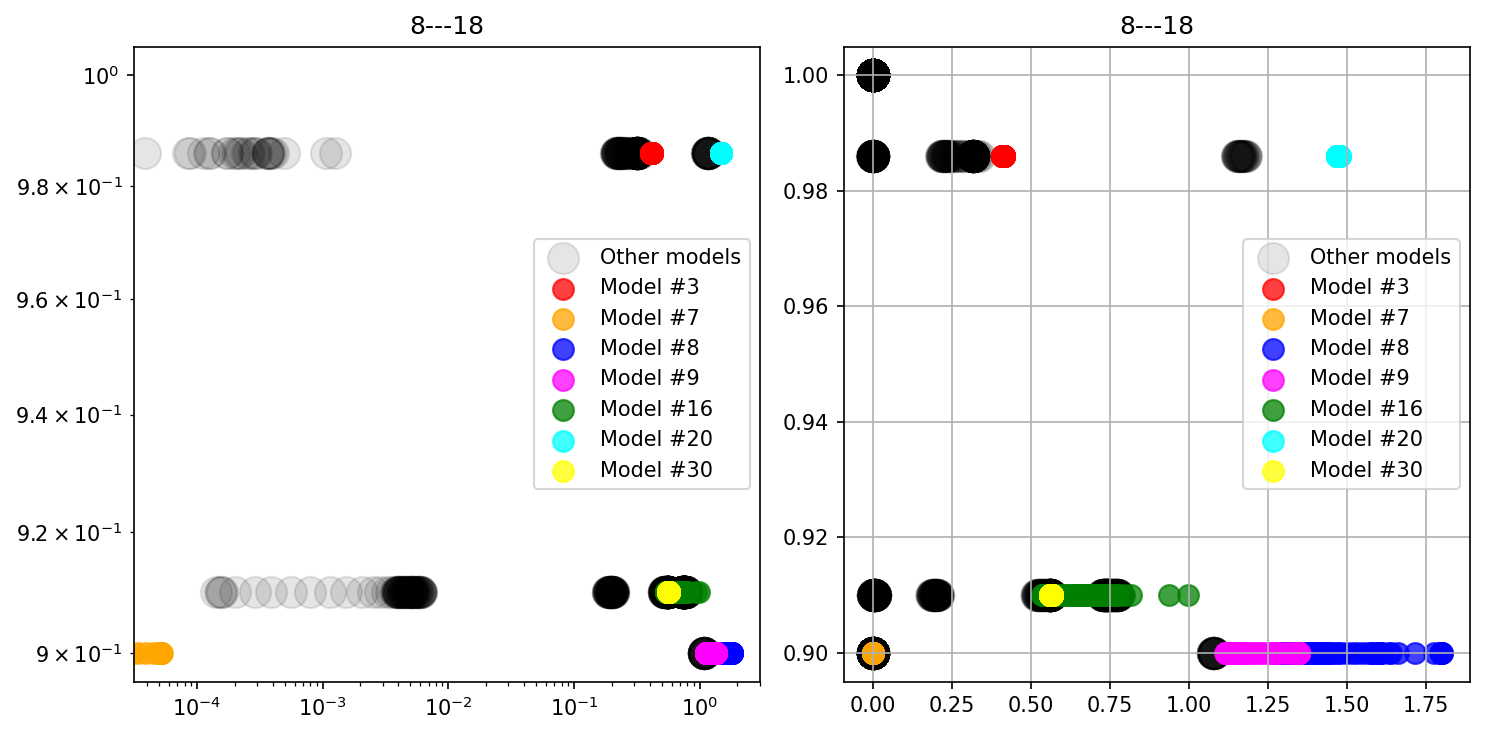

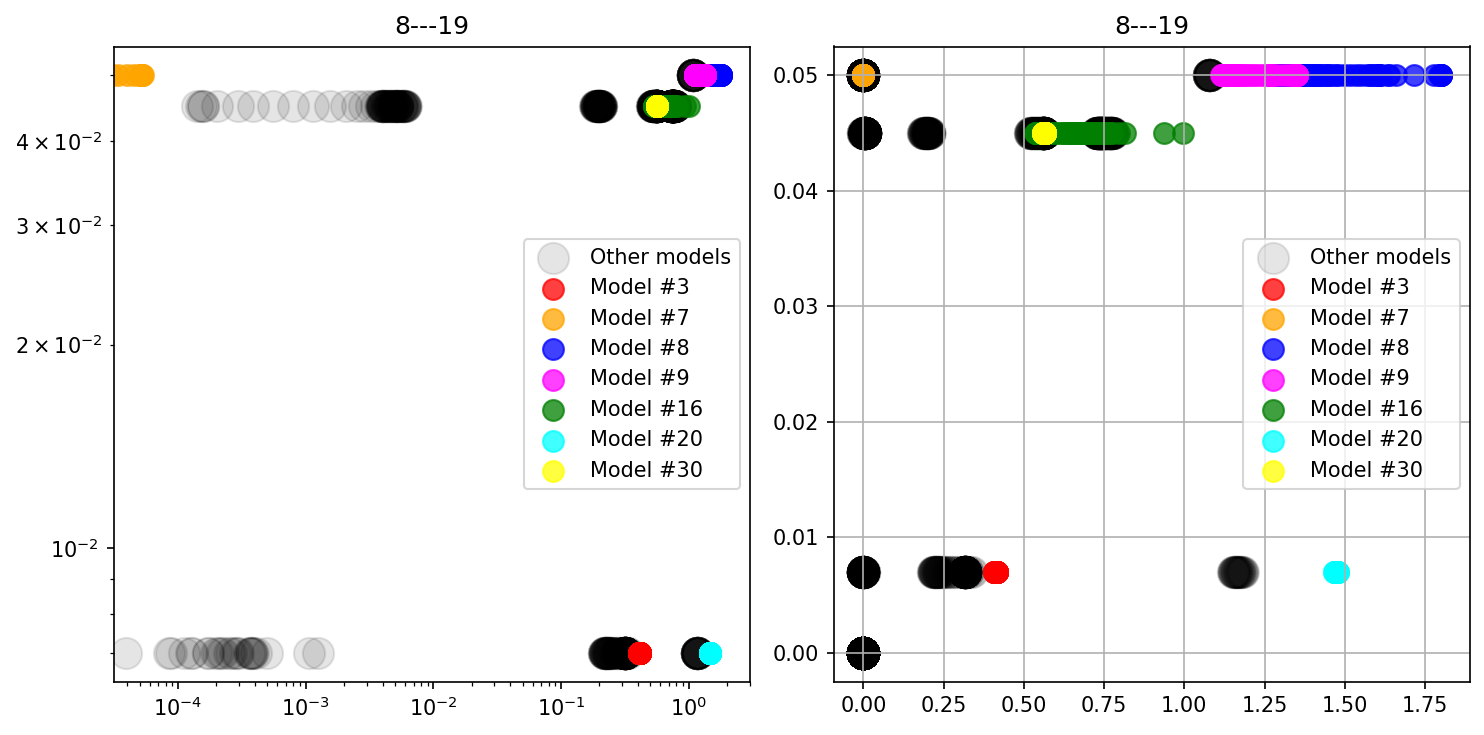

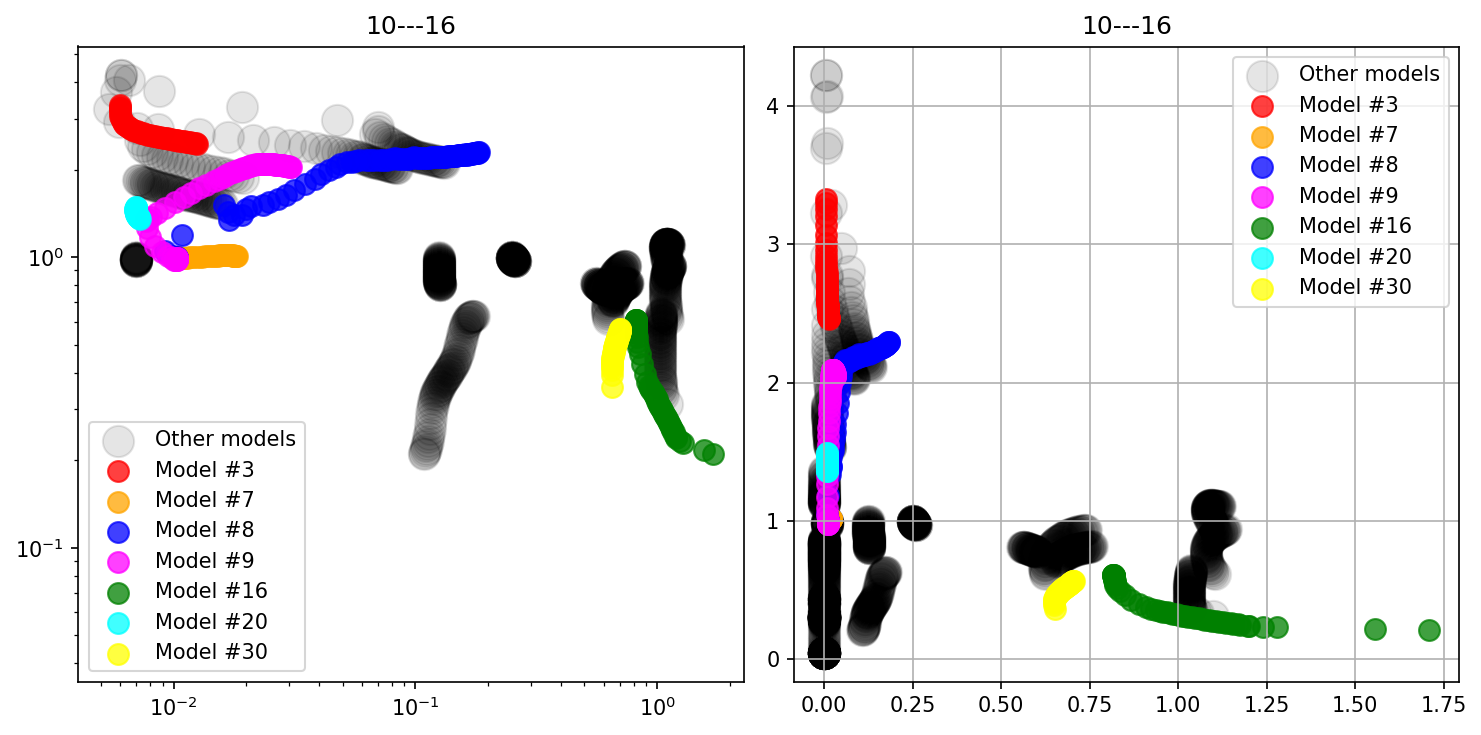

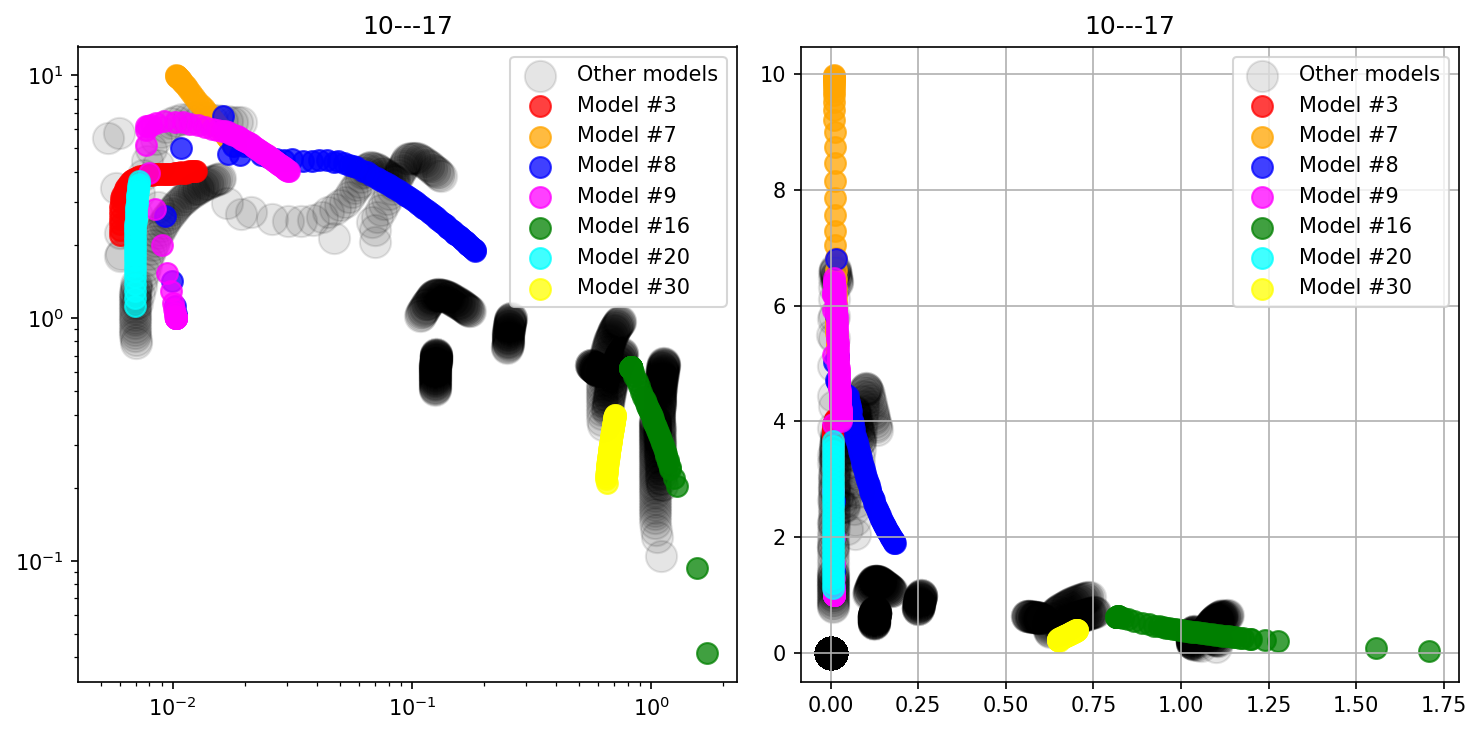

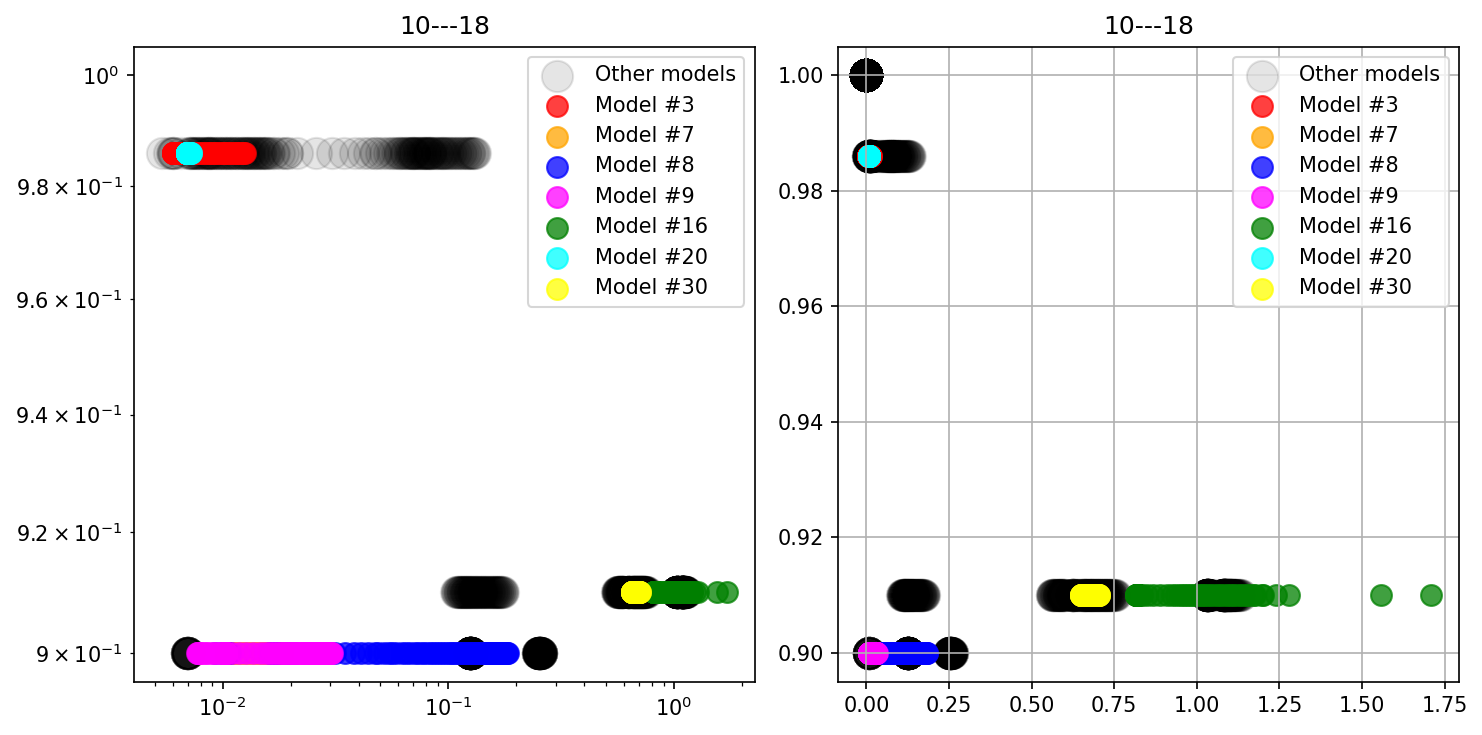

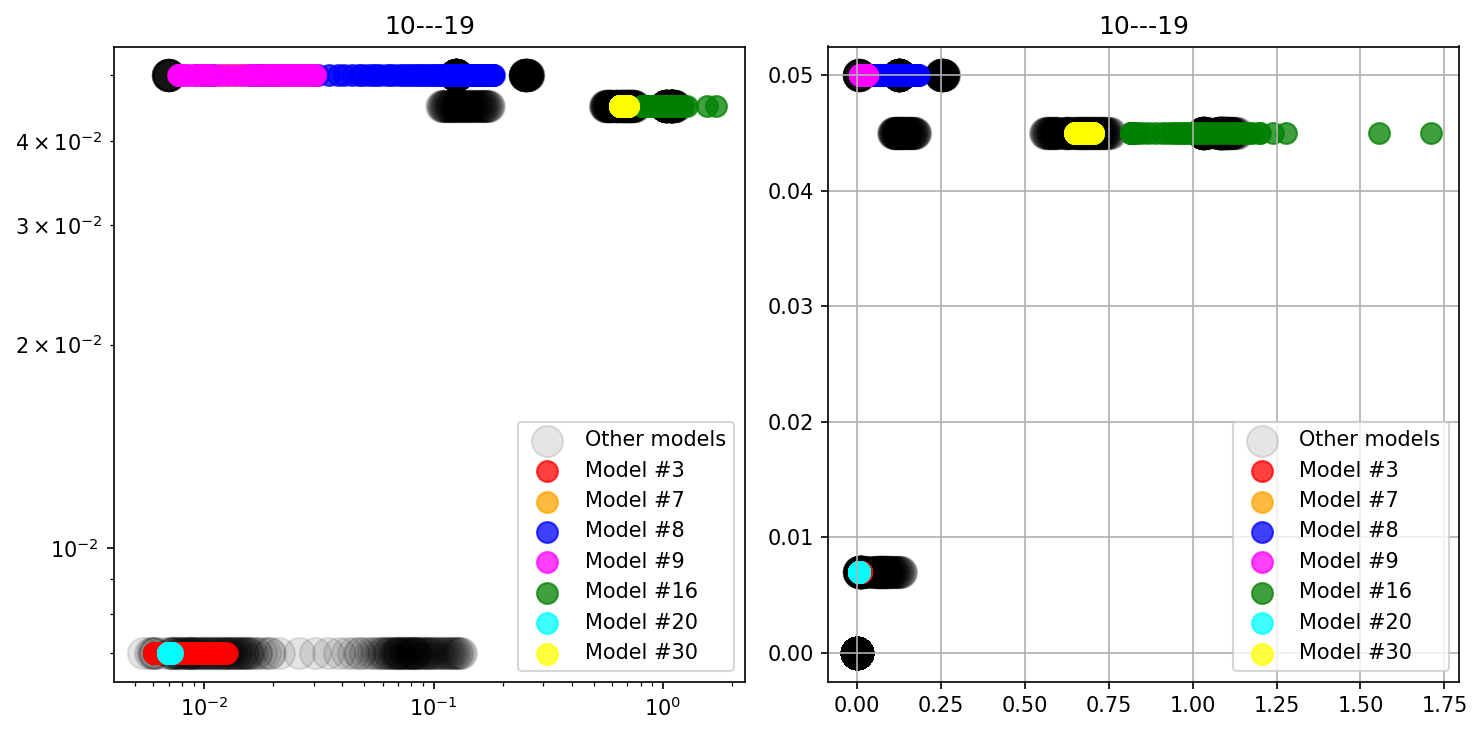

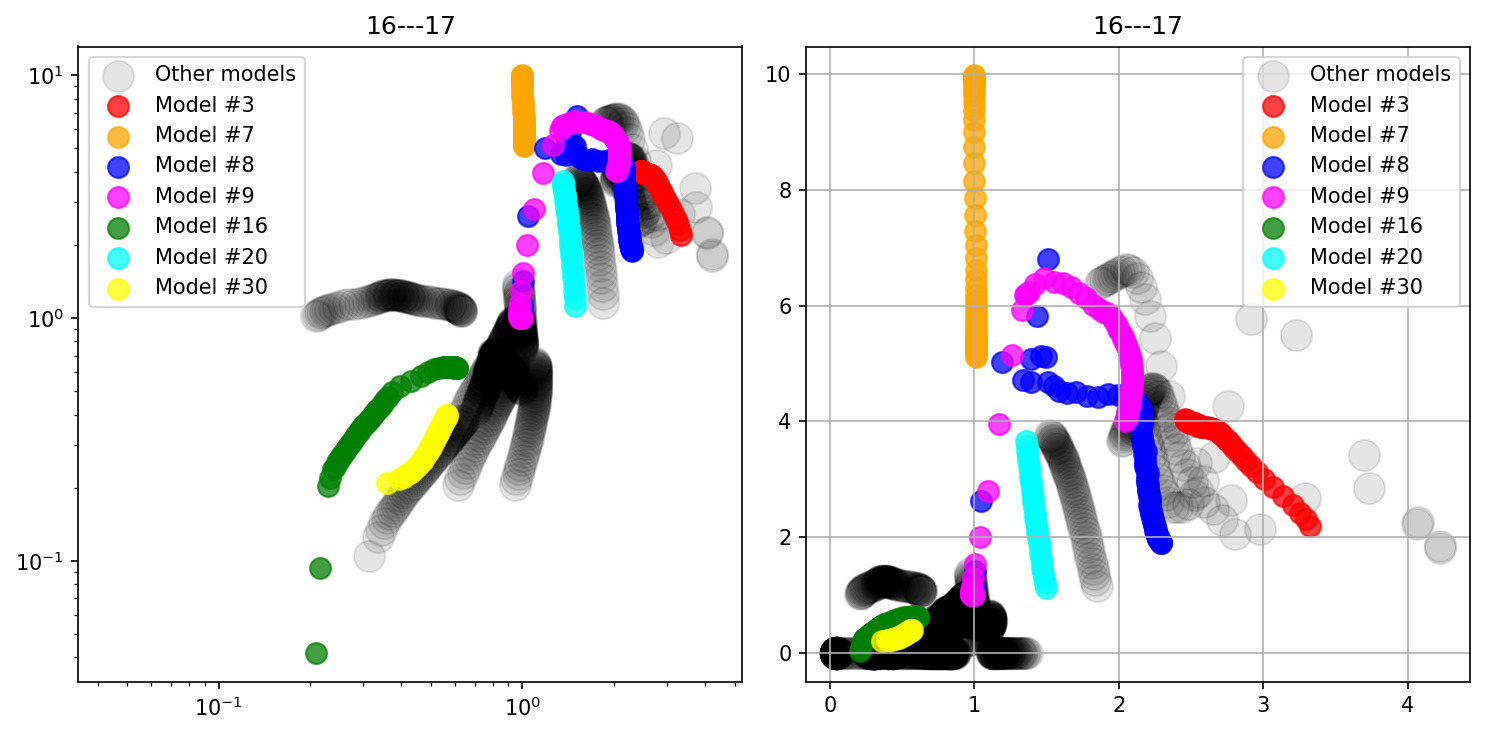

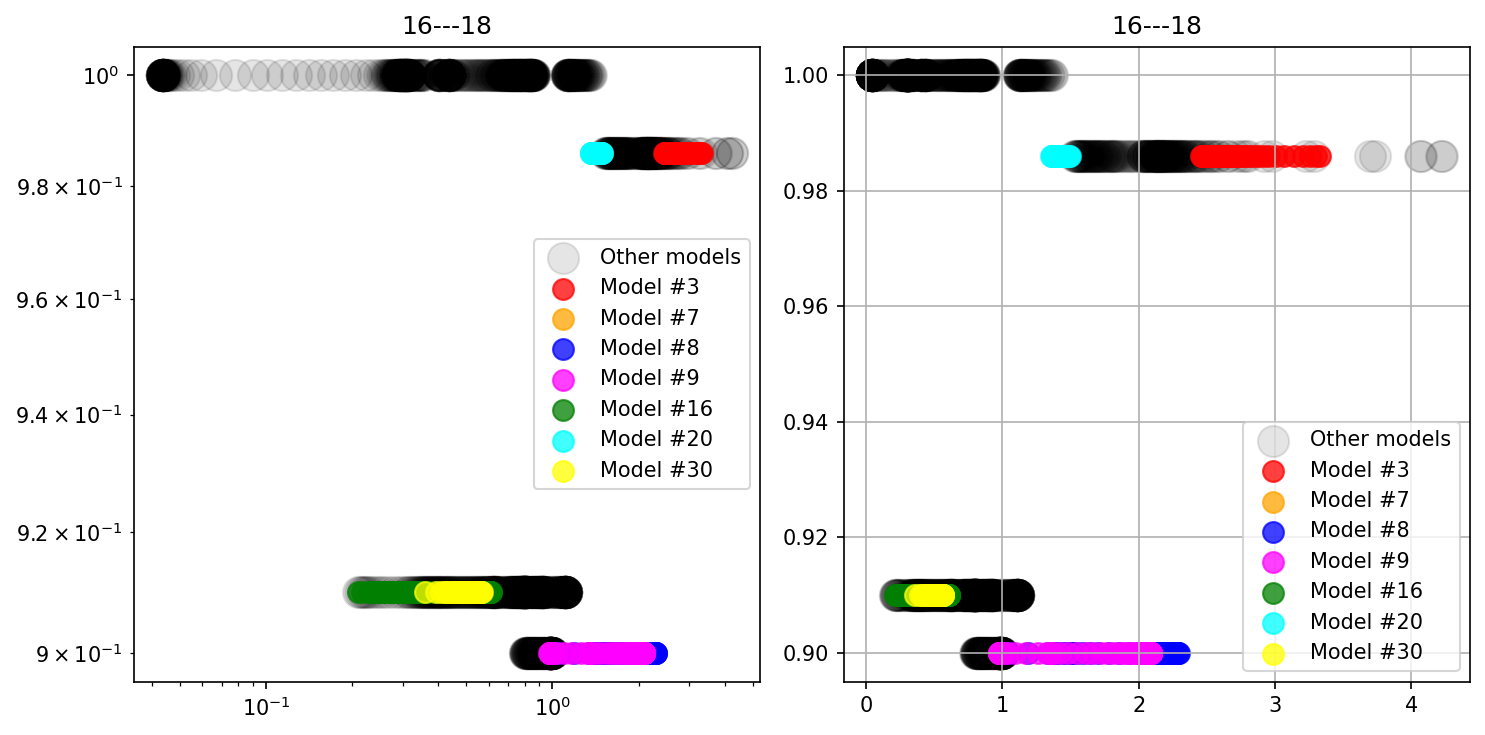

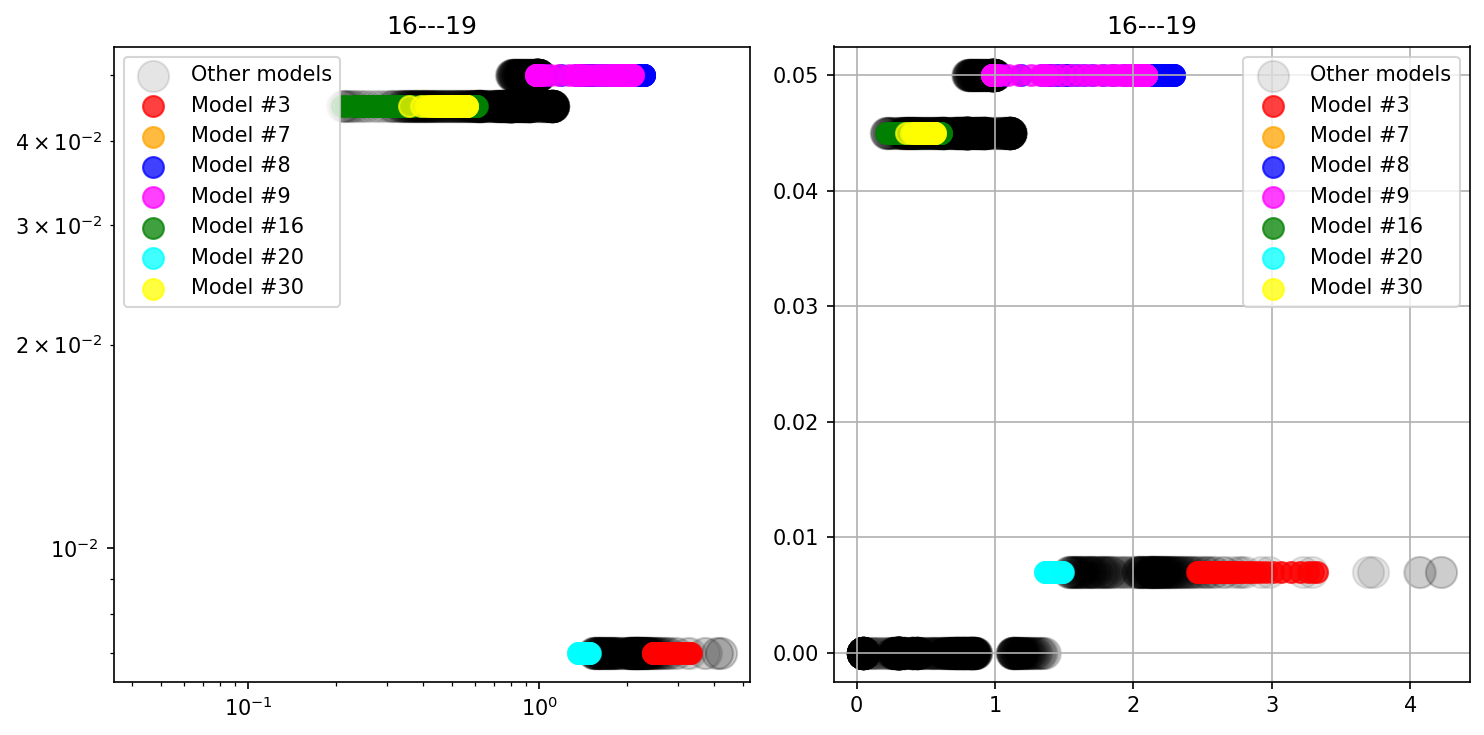

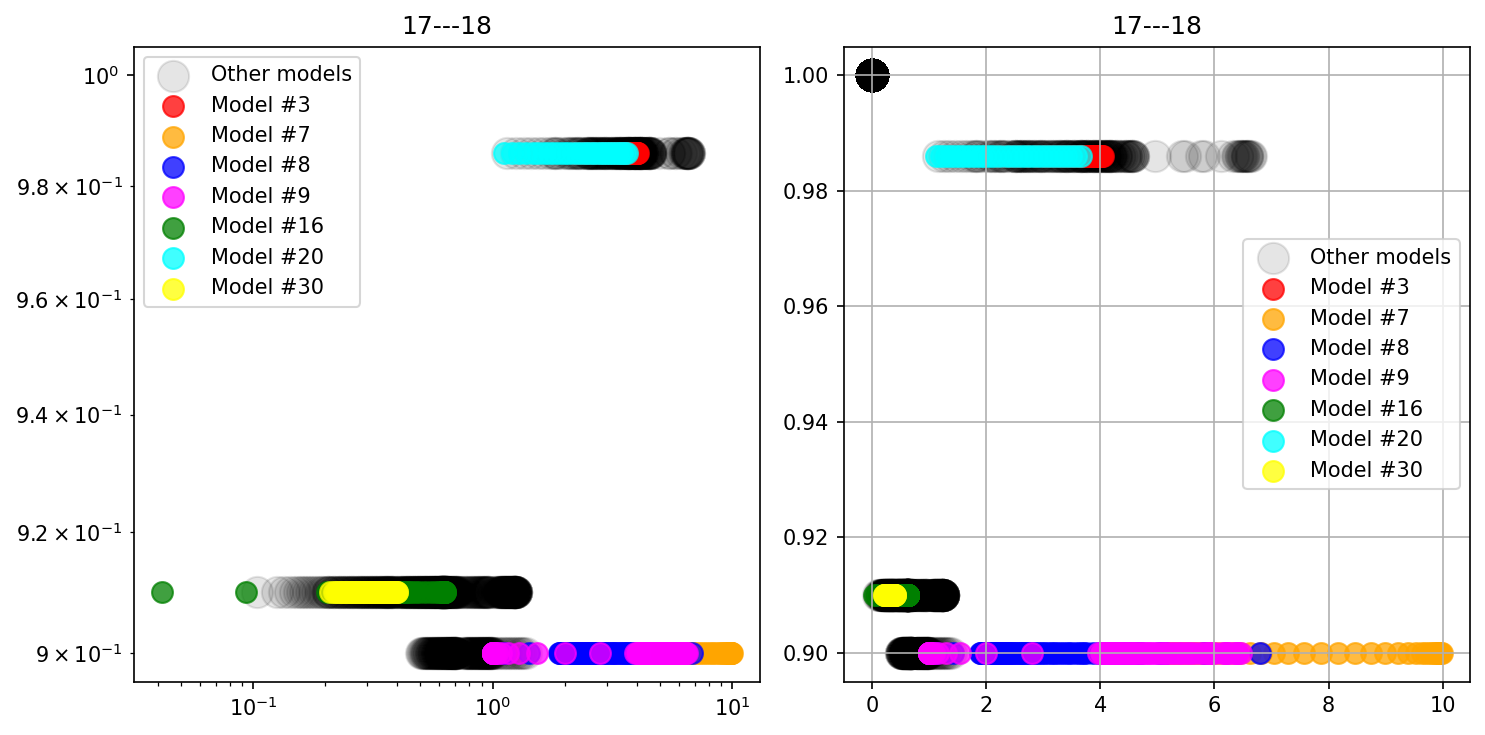

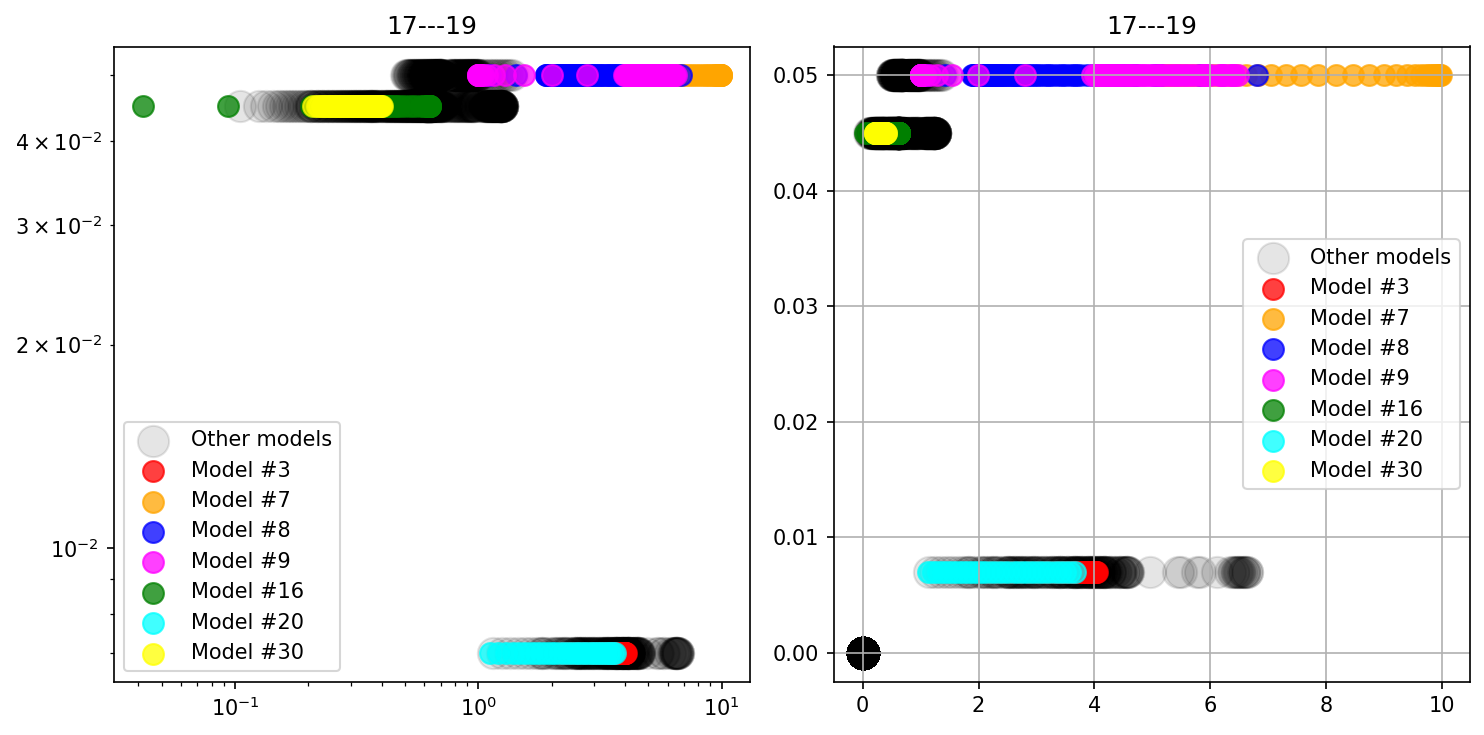

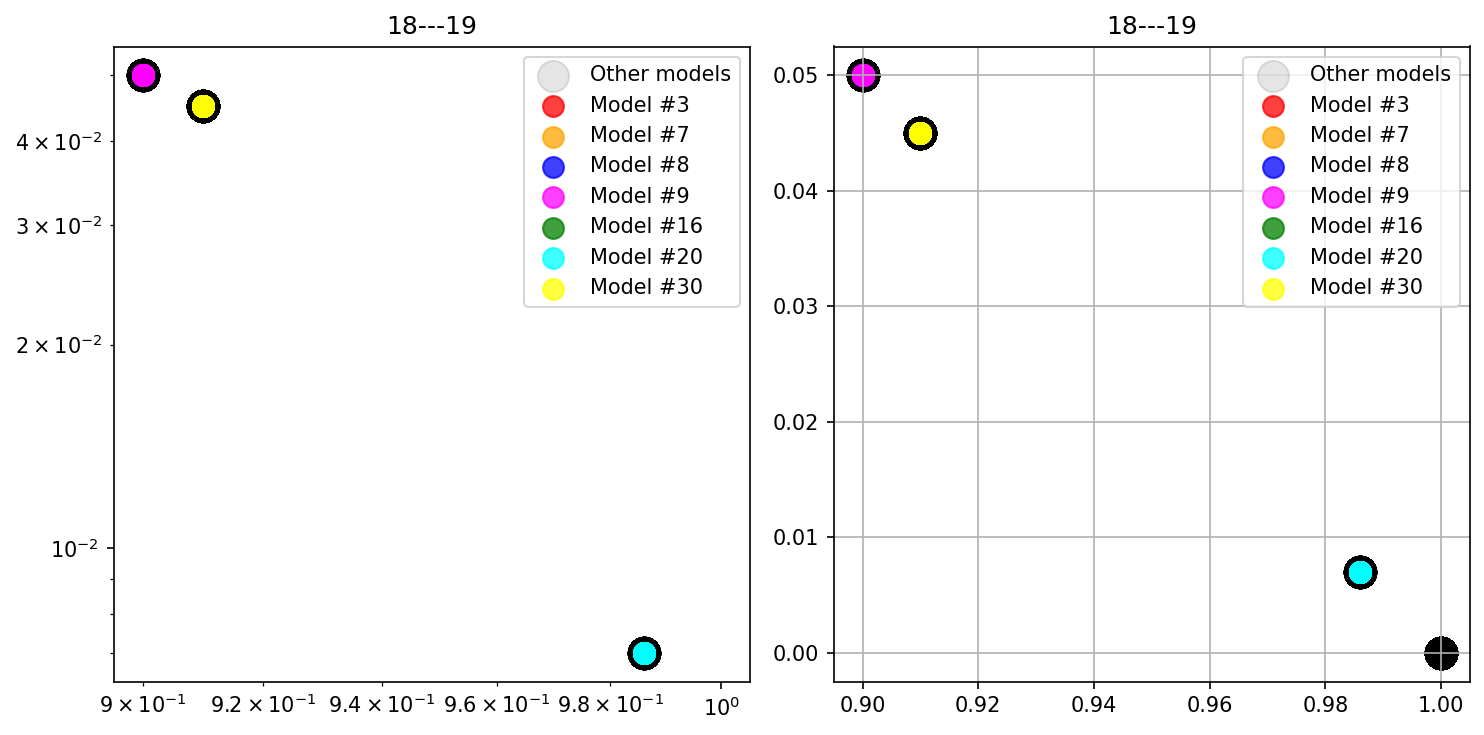

In [40]:
indexes = [0, 2, 8, 10, 16, 17, 18, 19]

for index1 in indexes:
    for index2 in indexes:
        
        if (index2 <= index1): continue

        featurevector_allmoments = np.load('./mldata_vdfmoments/allsimulations.featurevector_allmoments_all.npy')
        p_be = featurevector_allmoments[:,index1]
        p_an = featurevector_allmoments[:,index2]

        matplotlib.rcParams.update({'font.size':10})

        im, ax = plt.subplots(1, 2, figsize=(10,5), dpi=150)

        plt.grid(True)

        for nm, simfile in enumerate(simfiles):
            test_index = np.where(simnames == simfile)[0]
            if (nm == 0):
                ax[0].scatter(p_be[test_index], p_an[test_index], color='black', alpha=0.10, label='Other models', s=225)
                continue
            if (nm not in [2, 6, 7, 8, 15, 19, 29]): ax[0].scatter(p_be[test_index], p_an[test_index], color='black', alpha=0.10, s=225)

        for nm, simfile in enumerate(simfiles):
            test_index = np.where(simnames == simfile)[0]
            if (nm == 2): ax[0].scatter(p_be[test_index], p_an[test_index], color='red', alpha=0.75, label='Model #3', s=100)
            if (nm == 6): ax[0].scatter(p_be[test_index], p_an[test_index], color='orange', alpha=0.75, label='Model #7', s=100)
            if (nm == 7): ax[0].scatter(p_be[test_index], p_an[test_index], color='blue', alpha=0.75, label='Model #8', s=100)
            if (nm == 8): ax[0].scatter(p_be[test_index], p_an[test_index], color='magenta', alpha=0.75, label='Model #9', s=100)
            if (nm == 15): ax[0].scatter(p_be[test_index], p_an[test_index], color='green', alpha=0.75, label='Model #16', s=100)
            if (nm == 19): ax[0].scatter(p_be[test_index], p_an[test_index], color='cyan', alpha=0.75, label='Model #20', s=100)
            if (nm == 29): ax[0].scatter(p_be[test_index], p_an[test_index], color='yellow', alpha=0.75, label='Model #30', s=100)


        ax[0].set(xscale='log', yscale='log', title=str(index1) + '---' + str(index2))
        ax[0].legend()
        
        plt.grid(True)

        for nm, simfile in enumerate(simfiles):
            test_index = np.where(simnames == simfile)[0]
            if (nm == 0):
                ax[1].scatter(p_be[test_index], p_an[test_index], color='black', alpha=0.10, label='Other models', s=225)
                continue
            if (nm not in [2, 6, 7, 8, 15, 19, 29]): ax[1].scatter(p_be[test_index], p_an[test_index], color='black', alpha=0.10, s=225)

        for nm, simfile in enumerate(simfiles):
            test_index = np.where(simnames == simfile)[0]
            if (nm == 2): ax[1].scatter(p_be[test_index], p_an[test_index], color='red', alpha=0.75, label='Model #3', s=100)
            if (nm == 6): ax[1].scatter(p_be[test_index], p_an[test_index], color='orange', alpha=0.75, label='Model #7', s=100)
            if (nm == 7): ax[1].scatter(p_be[test_index], p_an[test_index], color='blue', alpha=0.75, label='Model #8', s=100)
            if (nm == 8): ax[1].scatter(p_be[test_index], p_an[test_index], color='magenta', alpha=0.75, label='Model #9', s=100)
            if (nm == 15): ax[1].scatter(p_be[test_index], p_an[test_index], color='green', alpha=0.75, label='Model #16', s=100)
            if (nm == 19): ax[1].scatter(p_be[test_index], p_an[test_index], color='cyan', alpha=0.75, label='Model #20', s=100)
            if (nm == 29): ax[1].scatter(p_be[test_index], p_an[test_index], color='yellow', alpha=0.75, label='Model #30', s=100)

        ax[1].set(title=str(index1) + '---' + str(index2))
        ax[1].legend()

        plt.tight_layout()
        plt.show()